In [1]:
%cd /home/jovyan/dea_intertidal/dea-intertidal

/home/jovyan/dea_intertidal/dea-intertidal


In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext autoreload
%autoreload 2

import datacube
import cmocean
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython import display
from IPython.core.display import Video
from ipywidgets import Output, GridspecLayout

import odc.geo.xr
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from dea_tools.plotting import display_map, xr_animation, rgb

from intertidal.exposure import exposure

In [4]:
dc = datacube.Datacube(app='Customising_Intertidal_Exposure')

In [5]:
# Identify your area of interest as degree lat/lon coordinates as well
# your nominated time period as start and end dates
study_area = "Smithburne_River_Qld"
query_params = dict(y=(-17.05121, -17.10617),
                    x=(140.90808, 140.97289),
                    time=("2016", "2022"))

# 17.05121°S, 140.90808°E
# 17.10617°S, 140.97289°E


# View the area of interest over a generic basemap. Data will be loaded
# inside the red bounding box.
display_map(x=query_params["x"], y=query_params["y"])

In [6]:
# Load DEA Intertidal for the area of interest, and mask out invalid
# nodata values
ds = dc.load(product="ga_s2ls_intertidal_cyear_3", **query_params)
ds = mask_invalid_data(ds)

In [7]:
dem = ds.elevation

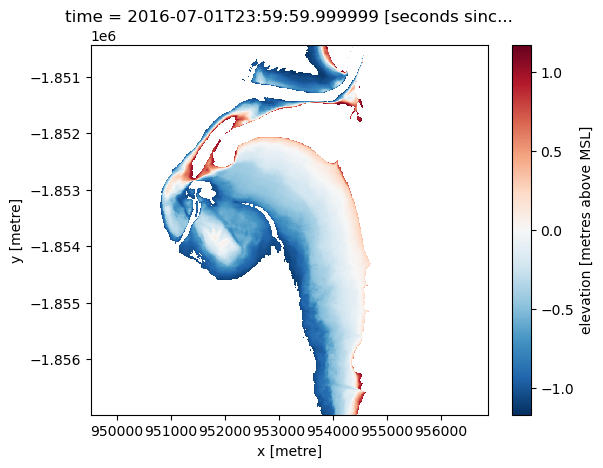

In [8]:
dem.sel(time='2016').plot()

In [86]:
%reload_ext autoreload

In [87]:
# Run the exposure algorithm and output the full tide model and the filtered tide model

# Identify a single timestep to inspect
time = np.datetime_as_string(ds.time.values, unit="Y")[0]

# tide_model = "ensemble"  # Tide model to use in analysis
# tide_model_dir = "/gdata1/data/tide_models_clipped"
start_date = str(np.datetime64(time) - np.timedelta64(1,'Y'))  # Start date for analysis
end_date = str(np.datetime64(time) + np.timedelta64(1,'Y'))  # End date for analysis
# modelled_freq = "30min"  # Frequency to run tidal model e.g '30min' or '1h'
# filters=["low_tide", "high_tide", "spring_high", "spring_low", "neap_high", "neap_low"] # Exposure filters eg None, ['Dry', 'Neap_low']
filters_combined = [("daylight","summer"),("daylight","autumn"),("daylight","winter"),("daylight","spring")] ## Must be a list of tuples containing one temporal and spatial filter each, eg None or [('Einter','Lowtide')]

# time_range = pd.date_range(
#     start=round_date_strings(start_date, round_type="start"),
#     end=round_date_strings(end_date, round_type="end"),
#     freq=modelled_freq,
# )

# calculate_quantiles = np.linspace(0, 1, 101) #nb formerly 'pc_range'

# Identify the filters to use to identify datetimes of interest from the high res tidal model
# filters = None#['unfiltered']
# filters_combined=[('Summer','Daylight')]

exposure_ds, modelledtides_ds, modelledtides_1d,timeranges,peaks= exposure(#exposure_filters,modelledtides_ds, timeranges, modelledtides_1d = exposure(
    dem=ds.elevation.sel(time=time),
    start_date=str(np.datetime64(time) - np.timedelta64(1,'Y')),
    end_date=str(np.datetime64(time) + np.timedelta64(1,'Y')),
    # modelled_freq = '1h',
    # tide_model="ensemble",
    # tide_model_dir=tide_model_dir,
    # filters=filters,
    filters_combined=filters_combined,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 in parallel


100%|██████████| 5/5 [01:25<00:00, 17.04s/it]


Returning low resolution tide array
Filtering timesteps for daylight
Filtering timesteps for summer
Filtering timesteps for autumn
Filtering timesteps for winter
Filtering timesteps for spring
Calculating unfiltered exposure
Calculating daylight exposure
Calculating summer exposure
Calculating autumn exposure
Calculating winter exposure
Calculating spring exposure
Calculating daylight_summer exposure
Calculating daylight_autumn exposure
Calculating daylight_winter exposure
Calculating daylight_spring exposure


In [88]:
exposure_ds

<xarray.Dataset> Size: 38MB
Dimensions:          (y: 654, x: 734, time: 1)
Coordinates:
  * y                (y) float64 5kB -1.85e+06 -1.85e+06 ... -1.857e+06
  * x                (x) float64 6kB 9.495e+05 9.495e+05 ... 9.568e+05 9.569e+05
    spatial_ref      int32 4B 3577
  * time             (time) datetime64[ns] 8B 2016-07-01T23:59:59.999999
Data variables:
    unfiltered       (y, x, time) float64 4MB nan nan nan nan ... nan nan nan
    daylight         (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    summer           (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    autumn           (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    winter           (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    spring           (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    daylight_summer  (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    daylight_autumn  (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    daylight_winter  (time, y, x) float64 4MB nan nan nan nan ... nan nan nan
    daylight_spring  (time, y, x) float64 4MB nan nan nan nan ... nan nan nan

In [89]:
list(exposure_ds.keys())

['unfiltered',
 'daylight',
 'summer',
 'autumn',
 'winter',
 'spring',
 'daylight_summer',
 'daylight_autumn',
 'daylight_winter',
 'daylight_spring']

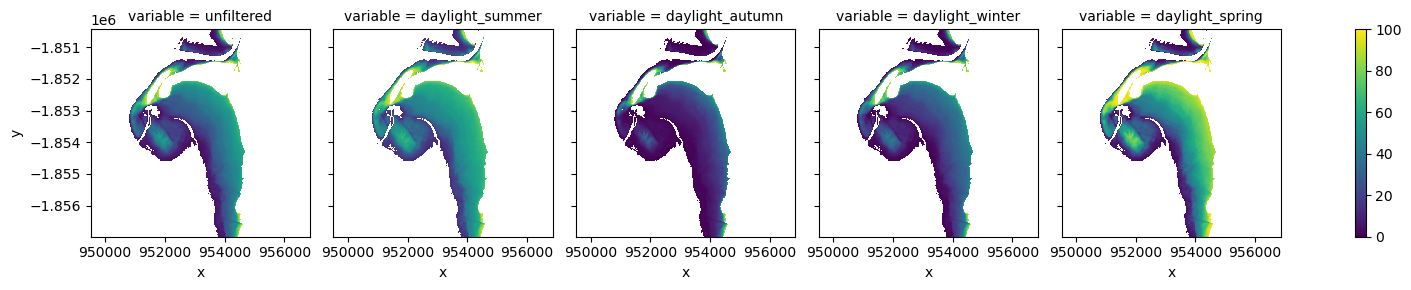

In [90]:
exposure_ds.drop_vars(['daylight','summer','autumn','winter','spring']).to_array().isel(time=0).plot(col='variable')

In [91]:
filters_low=list(exposure_ds.drop_vars(['daylight','summer','autumn','winter','spring','unfiltered']).keys())
filters_low

['daylight_summer', 'daylight_autumn', 'daylight_winter', 'daylight_spring']

In [92]:
# for k in filters_low:
#     timeranges.pop(k)
# filters_low[0]
# timeranges.pop('summer')
# timeranges
peaks

{}

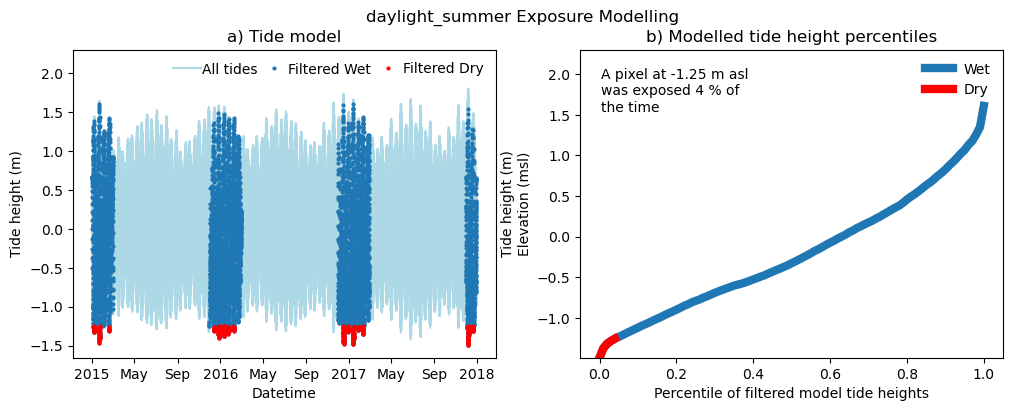

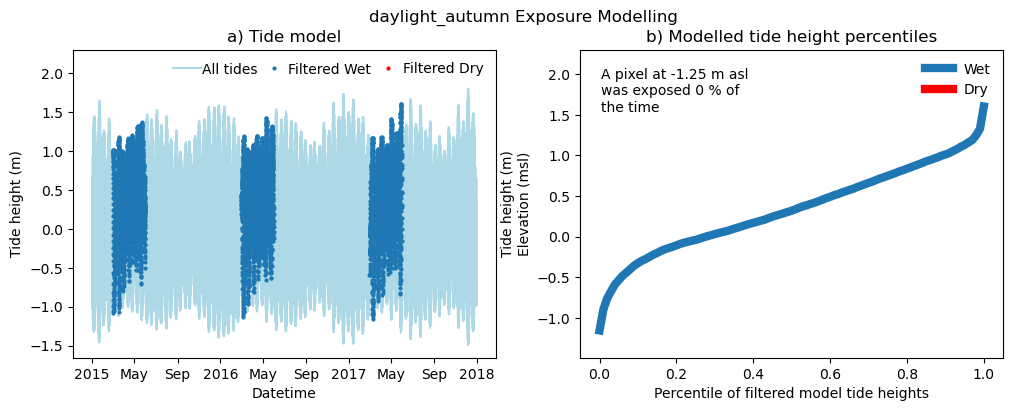

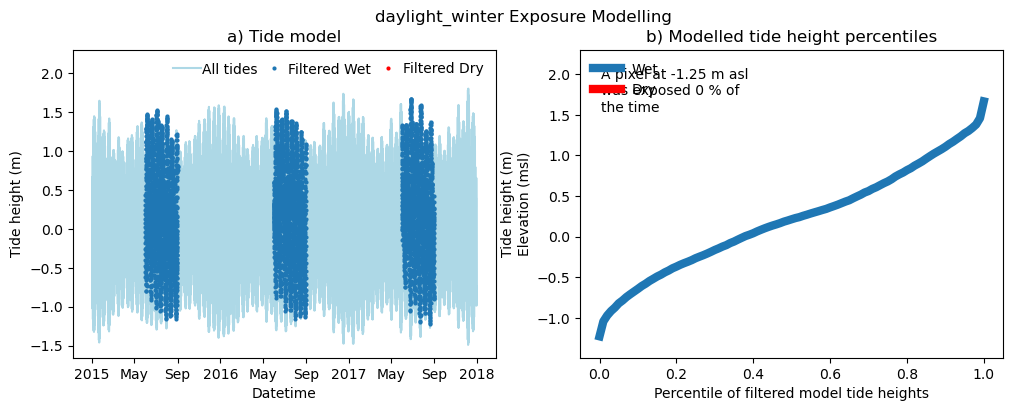

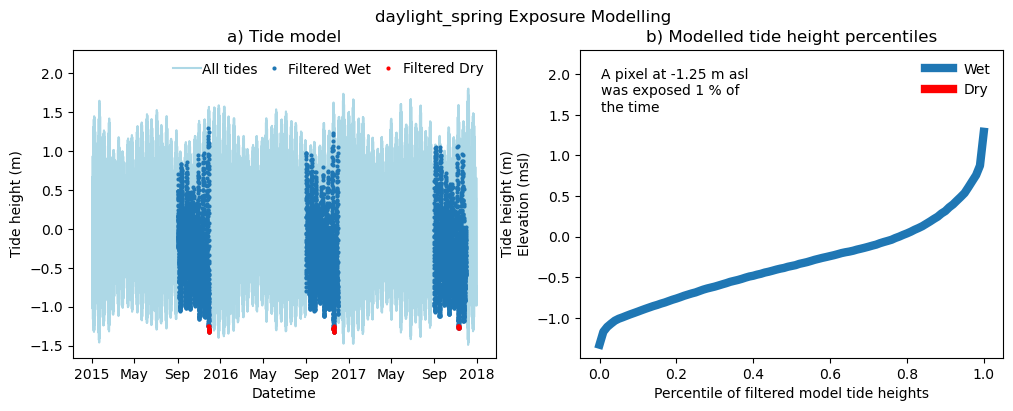

In [93]:
## Plot generation demonstrating exposure filter options

# Nominate which filter to plot from filters list eg filters[x]
# x = 5

for x in range(0,len(filters_low)):

    tidem = -1.25
    exp = abs(modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]) - tidem).idxmin(dim='quantile')*100

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # For filtered tide models

    # plot all tides
    modelledtides_1d.plot(ax=ax[0], label='All tides', color='lightblue', zorder=1)

    #plot filtered tides
    modelledtides_1d.sel(time=timeranges[filters_low[x]]).plot(linestyle='',marker='.', ax=ax[0], markeredgecolor='none', label='Filtered Wet', zorder=2)
    # if filters_low[x] == 'low_tide':
    #     ax[0].hlines(peaks[filters_low[x]].mean(),
    #                  timeranges[filters_low[x]][0],
    #                  timeranges[filters_low[x]][-1], 
    #                  color='black', 
    #                  zorder=4,
    #                 label='Peaks mean')
    # else:
    #     ax[0].hlines(modelledtides_1d.sel(time=timeranges[filters_low[x]]).max(),
    #                  timeranges[filters_low[x]][0],
    #                  timeranges[filters_low[x]][-1], 
    #                  color='black', 
    #                  zorder=4,
    #                 label='Peaks mean')
    # peaks[filters_low[x]].plot(ax=ax[0], marker='o', color='black', linestyle='', markersize='0.3', label=f'{filters_low[x]} peaks')

    # plot demonstration tides (for concept model where elevation = tidem)
    modelledtides_1d.sel(
        time=timeranges[filters_low[x]]).where(
        modelledtides_1d.sel(time=timeranges[filters_low[x]])<tidem).plot(
        linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Filtered Dry', zorder=3)

    # plot the cumulative frequency exposure curve
    modelledtides_ds[filters_low[x]].plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)

    # For unfiltered tide model only

    # exp = abs(modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)) - tidem).idxmin(dim='quantile')*100
    # modelledtides_1d.plot(ax=ax[0], label='Modelled tides - Wet', color='C0')
    # modelledtides_1d.where(modelledtides_1d<tidem).plot(linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Modelled tides - Dry')

    # modelledtides_ds[filters[0]].isel(x=1, y=1).plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    # modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)


    ax[0].set_title('a) Tide model')
    ax[0].set_ylabel('Tide height (m)')
    ax[0].set_ylim(ymax=modelledtides_1d.max()+0.5)
    ax[0].set_xlabel('Datetime')
    ax[0].legend(frameon=False, ncol=3, handletextpad=0.05, columnspacing=0.2)

    ax[1].set_title('b) Modelled tide height percentiles')
    ax[1].set_ylabel('Tide height (m)\nElevation (msl)')
    ax[1].set_ylim(ymin=modelledtides_1d.min() , ymax=modelledtides_1d.max()+0.5)
    ax[1].set_xlabel('Percentile of filtered model tide heights')
    ax[1].legend(frameon=False)
    ax[1].annotate(f'A pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.05, 0.8), xycoords='axes fraction')

    fig.suptitle(f'{filters_low[x]} Exposure Modelling')
    plt.savefig(f'{filters_low[x]}_Exp_concept_tideheight_filter')

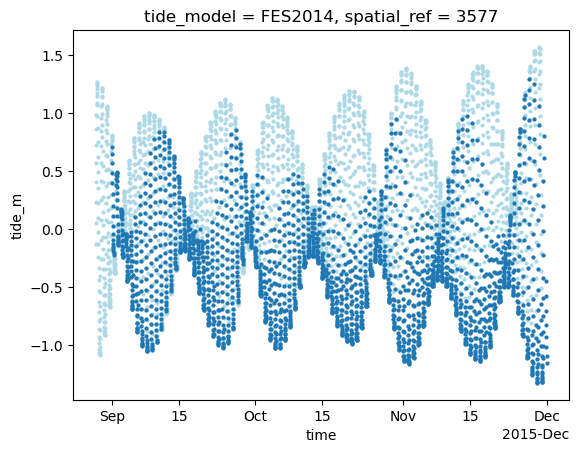

In [133]:
# plot all tides
modelledtides_1d[11500:16000].plot(label='All tides', color='lightblue', zorder=1, linestyle='',marker='.', markeredgecolor='none')

#plot filtered tides
# modelledtides_1d.sel(time=timeranges['daylight_spring']).plot(linestyle='',marker='.', markeredgecolor='none', label='Filtered Wet', zorder=2)
modelledtides_1d.sel(time=timeranges['daylight_spring'])[:2290].plot(linestyle='',marker='.', markeredgecolor='none', label='Filtered Wet', zorder=3)
# modelledtides_1d.sel(time=timeranges['spring'])[:4280].plot(linestyle='',marker='.', markeredgecolor='none', label='Night', zorder=2)

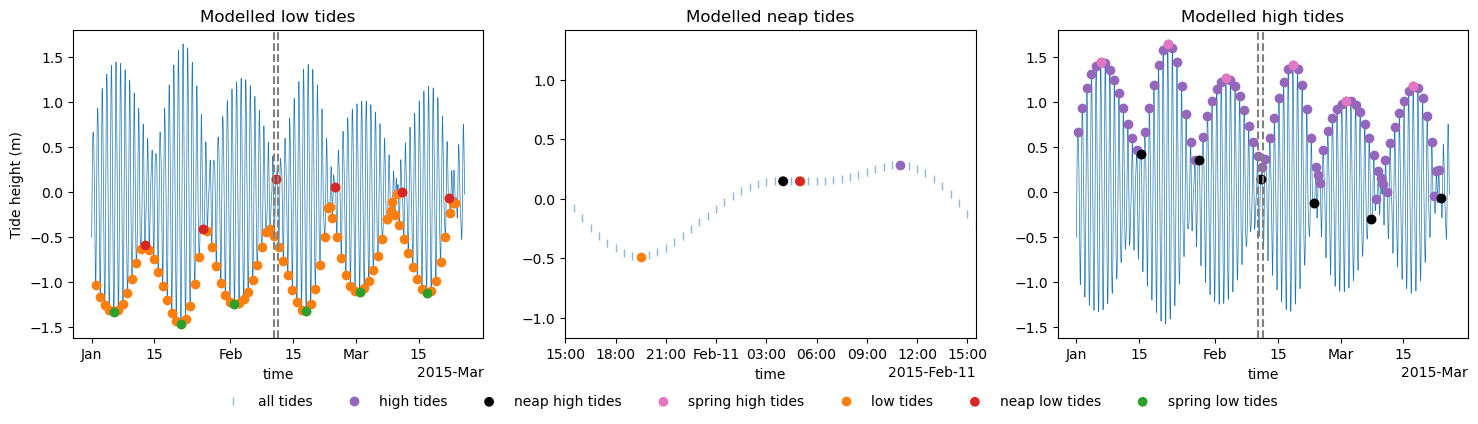

In [73]:
## Prototyping new spatial filter definitions as slices of the y-axis only

# low_mean = low_peaks2.mean()
# low_max = low_peaks2.max()

fig, ax = plt.subplots(1,3, figsize=(18,4))#, layout='constrained')

modelledtides_1d[:4000].plot(zorder=1, linewidth=0.5, ax=ax[0], label='all tides', color='C0')
peaks['low_tide'][0:90].plot(marker='o', linestyle='', zorder=1, ax=ax[0], label='low tides', color='C1')
peaks['neap_low'][0:6].plot(marker='o', linestyle='', zorder=2, ax=ax[0], label='neap low tides', color='C3')
peaks['spring_low'][0:6].plot(marker='o', linestyle='', zorder=3, ax=ax[0], label='spring low tides', color='C2')

modelledtides_1d[1700:2100].plot(marker='|', linestyle='',zorder=1, linewidth=0.5, ax=ax[1], label='all tides', color='C0', alpha=0.5)
peaks['high_tide'][35:45].plot(marker='o', linestyle='', zorder=1, ax=ax[1], label='high tides', color='C4')
peaks['neap_high'][2:3].plot.scatter(marker='o', linestyle='', zorder=2, ax=ax[1], label='neap high tides', color='black')
peaks['spring_high'][2:3].plot.scatter(marker='o', linestyle='', zorder=3, ax=ax[1], color='C6', label='spring high tides')
peaks['low_tide'][35:45].plot(marker='o', linestyle='', zorder=1, ax=ax[1], label= 'low tides', color='C1')
peaks['neap_low'][2:3].plot.scatter(marker='o', linestyle='', zorder=2, ax=ax[1], label='neap low tides', color='C3')
peaks['spring_low'][2:3].plot.scatter(marker='o', linestyle='', zorder=3, ax=ax[1], color='C2', label='spring low tides')

modelledtides_1d[:4000].plot(zorder=1, linewidth=0.5, ax=ax[2], label='all tides', color='C0')
peaks['high_tide'][0:90].plot(marker='o', linestyle='', zorder=1, ax=ax[2], label='high tides', color='C4')
peaks['neap_high'][0:6].plot(marker='o', linestyle='', zorder=2, ax=ax[2], label='neap high tides', color='black')
peaks['spring_high'][0:6].plot(marker='o', linestyle='', zorder=3, ax=ax[2], label='spring high tides', color='C6')

# plt.axhline(y=low_mean, xmin=0, xmax=len(low_peaks2), zorder=2, color='black')
# plt.axhline(y=low_max, xmin=0, xmax=len(low_peaks2), zorder=3, color='red')

ax[0].axvline(x=modelledtides_1d[1950:2000].time[0].values, 
              ymin=0,
              ymax=1,
             color='gray',
             linestyle='--')
ax[0].axvline(x=modelledtides_1d[1950:2000].time[-1].values, 
              ymin=0,
              ymax=1,
             color='gray',
             linestyle='--')
ax[2].axvline(x=modelledtides_1d[1950:2000].time[0].values, 
              ymin=0,
              ymax=1,
             color='gray',
             linestyle='--')
ax[2].axvline(x=modelledtides_1d[1950:2000].time[-1].values, 
              ymin=0,
              ymax=1,
             color='gray',
             linestyle='--')

ax[0].set_title('Modelled low tides')
ax[0].set_ylabel('Tide height (m)')

ax[1].set_title('Modelled neap tides')
ax[1].set_ylabel('')
ax[1].set_xlim(xmin=modelledtides_1d[1950:2000].time[0].values, xmax=modelledtides_1d[1950:2000].time[-1].values)
ax[1].set_ylim(ymin=peaks['low_tide'][35:45].min()*1.2 ,ymax=peaks['high_tide'][35:45].max()*1.2 )

ax[2].set_title("Modelled high tides")
ax[2].set_ylabel('')

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, ncol=7, loc='upper center',bbox_to_anchor=(0.5, 0.0))#, handletextpad=0.10, columnspacing=0.5)

# plt.savefig('Exp_concept_high_low_spring_neap_tides', bbox_inches='tight')

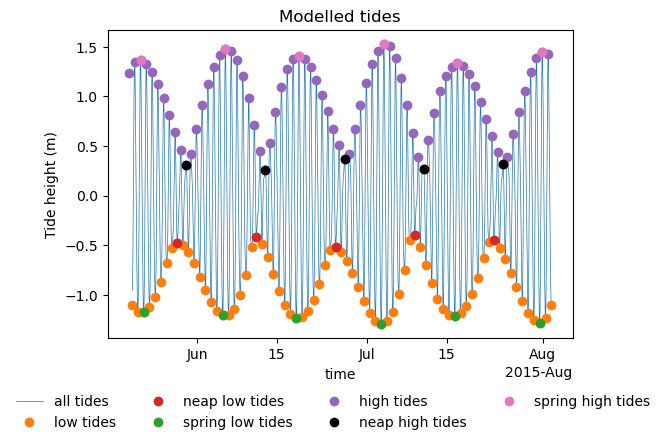

In [74]:
## Prototyping new spatial filter definitions as slices of the y-axis only

# low_mean = low_peaks2.mean()
# low_max = low_peaks2.max()

fig, ax = plt.subplots(1,1,figsize=(6,4))#, layout='constrained')

modelledtides_1d[6700:10250].plot(zorder=1, linewidth=0.5, ax=ax, label='all tides', color='C0')
peaks['low_tide'][155:230].plot(marker='o', linestyle='', zorder=1, ax=ax, label='low tides', color='C1')
peaks['neap_low'][10:15].plot(marker='o', linestyle='', zorder=2, ax=ax, label='neap low tides', color='C3')#, markersize=8)#alpha=0.5)
peaks['spring_low'][10:16].plot(marker='o', linestyle='', zorder=3, ax=ax, label='spring low tides', color='C2')

# modelledtides_1d[:4000].plot(zorder=1, linewidth=0.5, ax=ax[2], label='all tides', color='C0')
peaks['high_tide'][155:230].plot(marker='o', linestyle='', zorder=1, ax=ax, label='high tides', color='C4')
peaks['neap_high'][10:15].plot(marker='o', linestyle='', zorder=1, ax=ax, label='neap high tides', color='black')#, markersize=8)
peaks['spring_high'][10:16].plot(marker='o', linestyle='', zorder=3, ax=ax, label='spring high tides', color='C6')

ax.set_title('Modelled tides')
ax.set_ylabel('Tide height (m)')

# plt.tight_layout(w_space=1)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, ncol=4, loc='upper center',bbox_to_anchor=(0.5, 0.0))#, handletextpad=0.10, columnspacing=0.5)
# fig.get_layout_engine().set(w_pad=-0.5)
# plt.tight_layout()
# plt.savefig('Exp_concept_modelled_tides_peaks', bbox_inches='tight')

In [75]:
# timeranges[filters[5]]
print(filters)
filters_low = ['low_tide', 'spring_low', 'neap_low']
filters_high = ['high_tide', 'spring_high', 'neap_high']

['low_tide', 'high_tide', 'spring_high', 'spring_low', 'neap_high', 'neap_low']


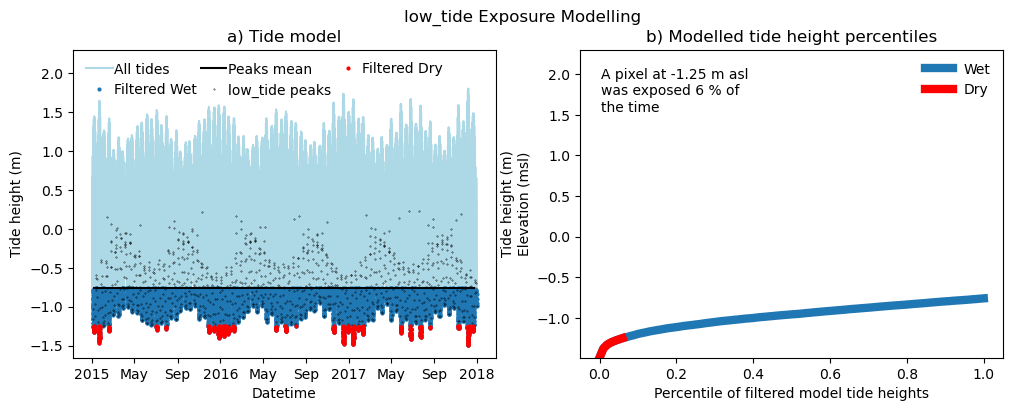

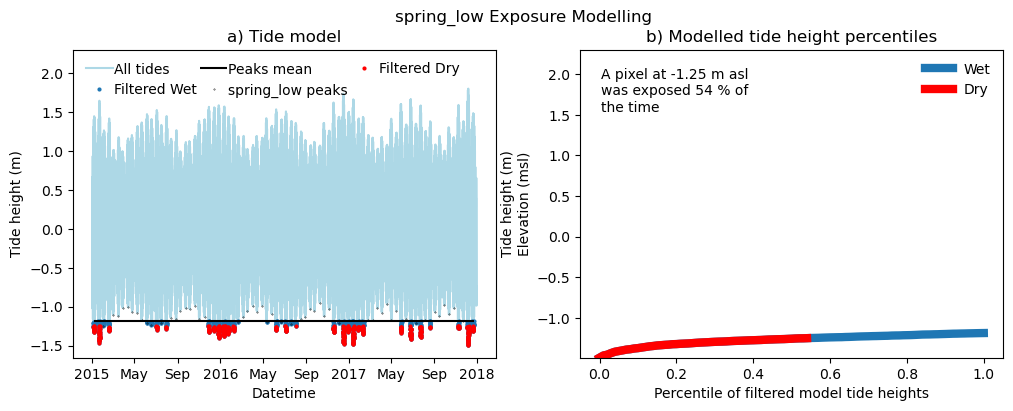

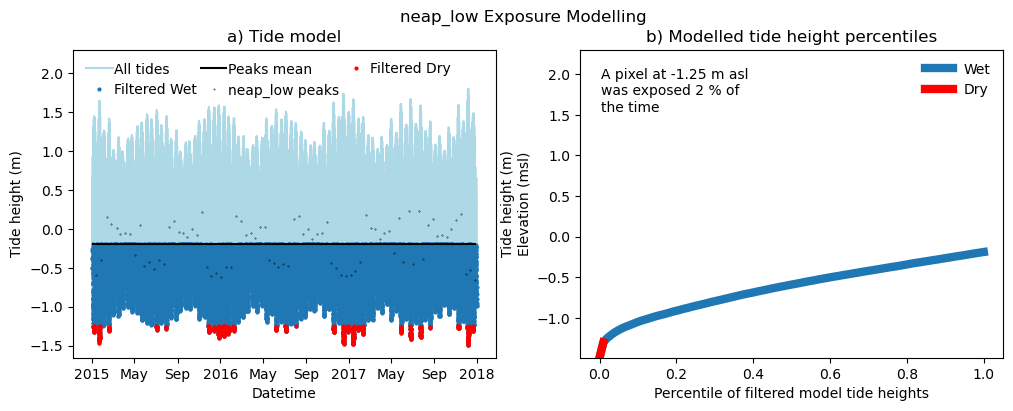

In [109]:
## Plot generation demonstrating exposure filter options

# Nominate which filter to plot from filters list eg filters[x]
# x = 5

for x in range(0,len(filters_low)):

    tidem = -1.25
    exp = abs(modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]) - tidem).idxmin(dim='quantile')*100

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # For filtered tide models

    # plot all tides
    modelledtides_1d.plot(ax=ax[0], label='All tides', color='lightblue', zorder=1)

    #plot filtered tides
    modelledtides_1d.sel(time=timeranges[filters_low[x]]).plot(linestyle='',marker='.', ax=ax[0], markeredgecolor='none', label='Filtered Wet', zorder=2)
    if filters_low[x] == 'low_tide':
        ax[0].hlines(peaks[filters_low[x]].mean(),
                     timeranges[filters_high[x]][0],
                     timeranges[filters_high[x]][-1], 
                     color='black', 
                     zorder=4,
                    label='Peaks mean')
    else:
        ax[0].hlines(modelledtides_1d.sel(time=timeranges[filters_low[x]]).max(),
                     timeranges[filters_high[x]][0],
                     timeranges[filters_high[x]][-1], 
                     color='black', 
                     zorder=4,
                    label='Peaks mean')
    peaks[filters_low[x]].plot(ax=ax[0], marker='o', color='black', linestyle='', markersize='0.3', label=f'{filters_low[x]} peaks')

    # plot demonstration tides (for concept model where elevation = tidem)
    modelledtides_1d.sel(
        time=timeranges[filters_low[x]]).where(
        modelledtides_1d.sel(time=timeranges[filters_low[x]])<tidem).plot(
        linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Filtered Dry', zorder=3)

    # plot the cumulative frequency exposure curve
    modelledtides_ds[filters_low[x]].plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    modelledtides_ds[filters_low[x]].where(modelledtides_ds[filters_low[x]]<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)

    # For unfiltered tide model only

    # exp = abs(modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)) - tidem).idxmin(dim='quantile')*100
    # modelledtides_1d.plot(ax=ax[0], label='Modelled tides - Wet', color='C0')
    # modelledtides_1d.where(modelledtides_1d<tidem).plot(linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Modelled tides - Dry')

    # modelledtides_ds[filters[0]].isel(x=1, y=1).plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    # modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)


    ax[0].set_title('a) Tide model')
    ax[0].set_ylabel('Tide height (m)')
    ax[0].set_ylim(ymax=modelledtides_1d.max()+0.5)
    ax[0].set_xlabel('Datetime')
    ax[0].legend(frameon=False, ncol=3, handletextpad=0.05, columnspacing=0.2)

    ax[1].set_title('b) Modelled tide height percentiles')
    ax[1].set_ylabel('Tide height (m)\nElevation (msl)')
    ax[1].set_ylim(ymin=modelledtides_1d.min() , ymax=modelledtides_1d.max()+0.5)
    ax[1].set_xlabel('Percentile of filtered model tide heights')
    ax[1].legend(frameon=False)
    ax[1].annotate(f'A pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.05, 0.8), xycoords='axes fraction')

    fig.suptitle(f'{filters_low[x]} Exposure Modelling')
    plt.savefig(f'{filters_low[x]}_Exp_concept_tideheight_filter')

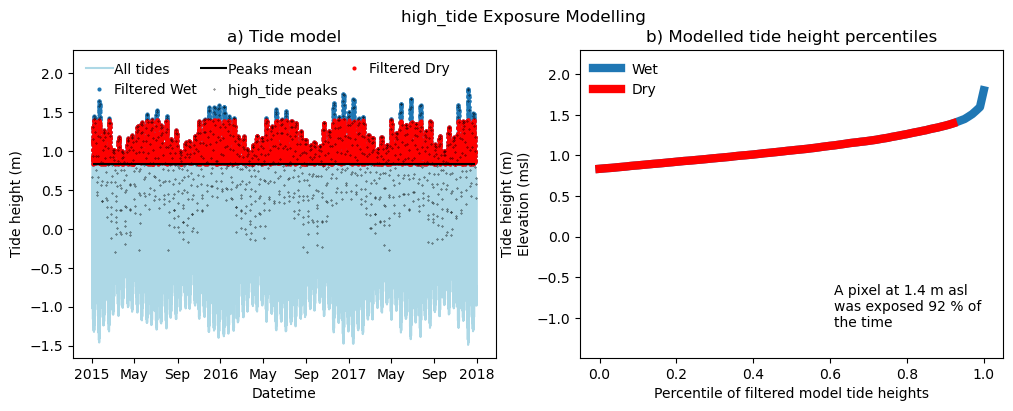

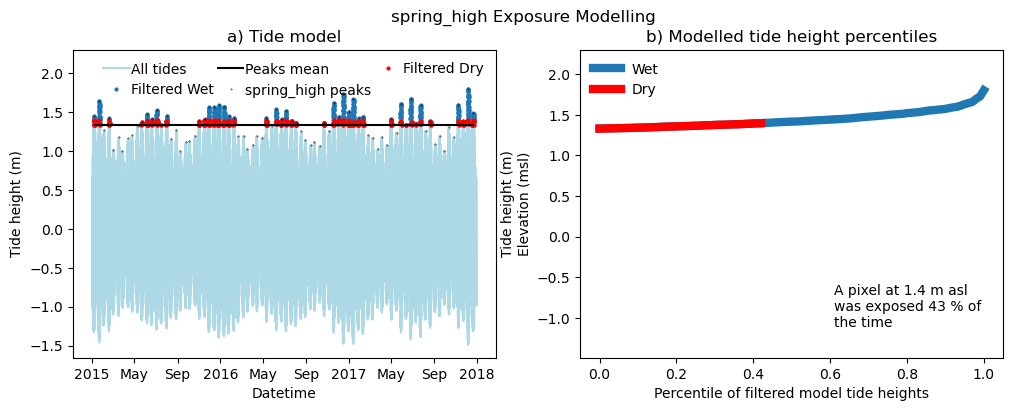

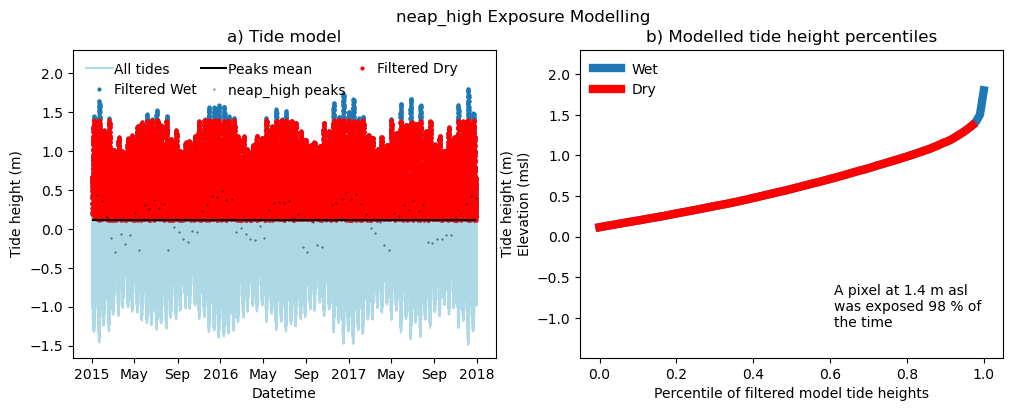

In [110]:
## Plot generation demonstrating exposure filter options

# Nominate which filter to plot from filters list eg filters[x]
# x = 5

for x in range(0,len(filters_high)):

    tidem = 1.4
    exp = abs(modelledtides_ds[filters_high[x]].where(modelledtides_ds[filters_high[x]]) - tidem).idxmin(dim='quantile')*100

    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # For filtered tide models

    # plot all tides
    modelledtides_1d.plot(ax=ax[0], label='All tides', color='lightblue', zorder=0)

    #plot filtered tides
    modelledtides_1d.sel(time=timeranges[filters_high[x]]).plot(linestyle='',marker='.', ax=ax[0], markeredgecolor='none', label='Filtered Wet', zorder=1)
    # modelledtides_1d.sel(time=peaks[filters_high[x]].time).plot(linestyle='',marker='.', ax=ax[0], markeredgecolor='none', label='Filtered tides-Wet')
    
    if filters_high[x] == 'high_tide':
        ax[0].hlines(
            peaks[filters_high[x]].mean(),
            timeranges[filters_high[x]][0],
            timeranges[filters_high[x]][-1],
            color='black', 
            zorder=6, 
            label='Peaks mean')
    else:
        ax[0].hlines(
            modelledtides_1d.sel(time=timeranges[filters_high[x]]).min(),
            timeranges[filters_high[x]][0],
            timeranges[filters_high[x]][-1], 
            color='black', 
            zorder=6, 
            label='Peaks mean')
    peaks[filters_high[x]].plot(ax=ax[0], marker='o', color='black', linestyle='', markersize='0.3', label=f'{filters_high[x]} peaks', zorder=6)
    
    # plot demonstration tides (for concept model where elevation = tidem)
    modelledtides_1d.sel(
        time=timeranges[filters_high[x]]).where(
        modelledtides_1d.sel(time=timeranges[filters_high[x]])<tidem).plot(
        linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Filtered Dry', zorder=2)

    # plot the cumulative frequency exposure curve
    modelledtides_ds[filters_high[x]].plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    modelledtides_ds[filters_high[x]].where(modelledtides_ds[filters_high[x]]<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)

    # For unfiltered tide model only

    # exp = abs(modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)) - tidem).idxmin(dim='quantile')*100
    # modelledtides_1d.plot(ax=ax[0], label='Modelled tides - Wet', color='C0')
    # modelledtides_1d.where(modelledtides_1d<tidem).plot(linestyle='',marker='.', ax=ax[0],color='red', markeredgecolor='none', label='Modelled tides - Dry')

    # modelledtides_ds[filters[0]].isel(x=1, y=1).plot(ax=ax[1],label='Wet', color='C0', linewidth=6)
    # modelledtides_ds[filters[0]].isel(x=1, y=1).where(modelledtides_ds[filters[0]].isel(x=1, y=1)<tidem).plot(ax=ax[1], color='red', label='Dry', linewidth=6)


    ax[0].set_title('a) Tide model')
    ax[0].set_ylabel('Tide height (m)')
    ax[0].set_ylim(ymax=modelledtides_1d.max()+0.5)
    ax[0].set_xlabel('Datetime')
    ax[0].legend(frameon=False, ncol=3, handletextpad=0.050, columnspacing=0.2)

    ax[1].set_title('b) Modelled tide height percentiles')
    ax[1].set_ylabel('Tide height (m)\nElevation (msl)')
    ax[1].set_ylim(ymin=modelledtides_1d.min() , ymax=modelledtides_1d.max()+0.5)
    ax[1].set_xlabel('Percentile of filtered model tide heights')
    ax[1].legend(frameon=False)
    ax[1].annotate(f'A pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.6, 0.1), xycoords='axes fraction')

    fig.suptitle(f'{filters_high[x]} Exposure Modelling')
    plt.savefig(f'{filters_high[x]}_Exp_concept_tideheight_filter')

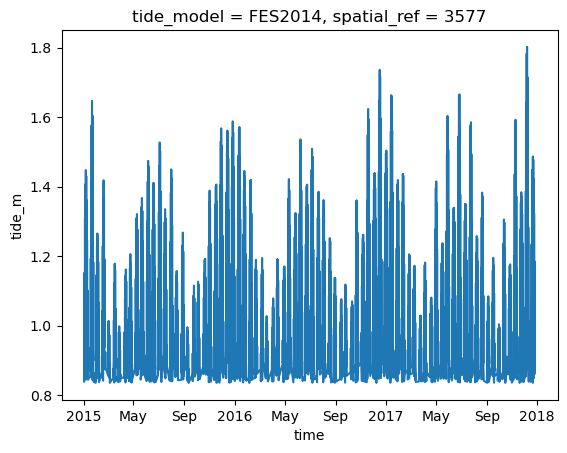

In [53]:

hightide = modelledtides_1d.where(
           modelledtides_1d >= peaks['high_tide'].mean(),
           drop=True
            )

modelledtides_1d.sel(time=timeranges['high_tide']).plot()
# modelledtides_1d.sel(time=peaks['high_tide'].time).plot()
# peaks['high_tide'].plot()
# hightide.plot()

In [49]:
print(len(timeranges['high_tide']))
print(len(hightide))

6726
6726


In [43]:
# print(len(timeranges['high_tide']))
peaks['high_tide'].time

TypeError: 'DataArray' object is not callable

In [1]:
modelledtides_1d.plot()
modelledtides_1d.where(timeranges[filters[x]]).plot()
# plt.plot(timeranges[filters[x]], peaks[filters[x]])
plt.hlines(peaks[filters[x]].max(),timeranges[filters[x]][0],timeranges[filters[x]][-1], color='red')

# modelledtides_1d.sel(time=timeranges[filters[x]], tide_m=peaks[filters[x]]peaks[filters[x]]).plot(
# peaks[filters[x]].where(peaks[filters[x]].notnull())

NameError: name 'modelledtides_1d' is not defined

In [ ]:
tidem = -0.5
exp = abs(tide_cq_dict['unfiltered'].isel(x=1,y=1) - tidem).idxmin(dim='quantile')*100

plt.figure(figsize=[7,4])

tide_cq_dict['unfiltered'].isel(x=1,y=1).plot(label='Wet', color='lightblue', linewidth=6)
tide_cq_dict['unfiltered'].isel(x=1,y=1).where(tide_cq_dict['unfiltered'].isel(x=1,y=1) <= tidem).plot(color='red', label='Dry', linewidth=6)
plt.title('Modelled tide height percentiles')
plt.ylabel('Tide height (m)')
plt.xlabel('Percentile of model observations')
plt.legend(frameon=False)
plt.annotate(f'This pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.7, 0.1), xycoords='axes fraction')
plt.savefig(fname='Exposure method concept model')


In [26]:
# ModelledTides= pixel_tides_ensemble(
#                                     dem,
#                                     # calculate_quantiles=calculate_quantiles,
#                                     times=time_range,
#                                     model=tide_model,
#                                     directory=tide_model_dir,
#                                     ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
#                                     # top_n=3,
#                                     # reduce_method='mean',
#                                     resolution=6000,
#                                     resample = False
#                                     )

# stacked_everything = ModelledTides.mean(dim=["x","y"])

# # # Extract the modelling freq units
# # # Split the number and text characters in modelled_freq
# # freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
# # freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])

# # # Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
# # mod_timesteps = pd.Timedelta((29.5/2),"d")/pd.Timedelta(freq_time, freq_unit)

# # ## Identify kwargs for peak detection algorithm
# # order=(int(mod_timesteps/2))

# # tide_cq_dict={}
# # exposure={}
# # timeranges={}

In [27]:
plt.figure(figsize=[7,4])

stacked_everything.drop('spatial_ref').plot(color='darkorange')
plt.savefig(fname='Carnot_bay_30min_tide_model')

NameError: name 'stacked_everything' is not defined

<Figure size 700x400 with 0 Axes>

In [28]:
import sunriset
import datetime
import re
import pytz
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd

from shapely.geometry import Point
from shapely.ops import unary_union
from math import ceil
from datetime import timedelta
from pyproj import CRS, Transformer
from scipy.signal import argrelmax, argrelmin
from numpy import interp

from dea_tools.coastal import pixel_tides, model_tides
from intertidal.tide_modelling import pixel_tides_ensemble
from intertidal.utils import configure_logging, round_date_strings

def temporal_filters(x,
                     timeranges,
                     time_range,
                     dem):
    """
    Identify and extract temporal-specific dates and times to feed 
    into tidal modelling for custom exposure calculations.
    """

    if x == 'Dry':
        timeranges['Dry'] = time_range.drop(time_range[(time_range.month == 10)  # Wet season: Oct-Mar
                | (time_range.month == 11)
                | (time_range.month == 12)
                | (time_range.month == 1)
                | (time_range.month == 2)
                | (time_range.month == 3)
                ])
    elif x == 'Wet':
        timeranges['Wet'] = time_range.drop(time_range[(time_range.month == 4)  # Dry season: Apr-Sep
                | (time_range.month == 5)
                | (time_range.month == 6)
                | (time_range.month == 7)
                | (time_range.month == 8)
                | (time_range.month == 9)
                ])
    elif x == 'Summer':
        timeranges['Summer'] = time_range.drop(
            time_range[time_range.quarter != 1])
    elif x == 'Autumn':
        timeranges['Autumn'] = time_range.drop(
            time_range[time_range.quarter != 2])
    elif x == 'Winter':
        timeranges['Winter'] = time_range.drop(
            time_range[time_range.quarter != 3])
    elif x == 'Spring':
        timeranges['Spring'] = time_range.drop(
            time_range[time_range.quarter != 4])
    elif x == 'Jan':
        timeranges['Jan'] = time_range.drop(time_range[time_range.month != 1])
    elif x == 'Feb':
        timeranges['Feb'] = time_range.drop(time_range[time_range.month != 2])
    elif x == 'Mar':
        timeranges['Mar'] = time_range.drop(time_range[time_range.month != 3])
    elif x == 'Apr':
        timeranges['Apr'] = time_range.drop(time_range[time_range.month != 4])
    elif x == 'May':
        timeranges['May'] = time_range.drop(time_range[time_range.month != 5])
    elif x == 'Jun':
        timeranges['Jun'] = time_range.drop(time_range[time_range.month != 6])
    elif x == 'Jul':
        timeranges['Jul'] = time_range.drop(time_range[time_range.month != 7])
    elif x == 'Aug':
        timeranges['Aug'] = time_range.drop(time_range[time_range.month != 8])
    elif x == 'Sep':
        timeranges['Sep'] = time_range.drop(time_range[time_range.month != 9])
    elif x == 'Oct':
        timeranges['Oct'] = time_range.drop(time_range[time_range.month != 10])
    elif x == 'Nov':
        timeranges['Nov'] = time_range.drop(time_range[time_range.month != 11])
    elif x == 'Dec':
        timeranges['Dec'] = time_range.drop(time_range[time_range.month != 12])
    elif x in ['Daylight', 'Night']:

        # Identify the central coordinate directly from the dem GeoBox
        tidepost_lon_4326, tidepost_lat_4326 = dem.odc.geobox.extent.centroid.to_crs(
            "EPSG:4326").coords[0]

        # Coordinate point to locate the sunriset calculation
        point_4326 = Point(tidepost_lon_4326, tidepost_lat_4326)

        # Calculate the local sunrise and sunset times
        # Place start and end dates in correct format
        start = time_range[0]
        end = time_range[-1]
        startdate = datetime.date(pd.to_datetime(start).year,
                                  pd.to_datetime(start).month,
                                  pd.to_datetime(start).day)

        # Make 'all_timerange' time-zone aware
        localtides = time_range.tz_localize(
            tz=pytz.UTC) 

        # Replace the UTC datetimes from all_timerange with local times
        ModTides = pd.DataFrame(index=localtides)

        # Return the difference in years for the time-period.
        # Round up to ensure all modelledtide datetimes are captured in the solar model
        diff = pd.to_datetime(end) - pd.to_datetime(start)
        diff = int(ceil(diff.days/365))

        local_tz = 0

        # Model sunrise and sunset
        sun_df = sunriset.to_pandas(
            startdate, tidepost_lat_4326, tidepost_lon_4326, local_tz, diff)

        # Set the index as a datetimeindex to match the modelledtide df
        sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))

        # Append the date to each Sunrise and Sunset time
        sun_df['Sunrise dt'] = sun_df.index + sun_df['Sunrise']
        sun_df['Sunset dt'] = sun_df.index + sun_df['Sunset']

        # Create new dataframes where daytime and nightime datetimes are recorded, then merged
        # on a new `Sunlight` column
        daytime = pd.DataFrame(
            data='Sunrise', index=sun_df['Sunrise dt'], columns=['Sunlight'])
        nighttime = pd.DataFrame(
            data='Sunset', index=sun_df['Sunset dt'], columns=['Sunlight'])
        DayNight = pd.concat([daytime, nighttime], join='outer')
        DayNight.sort_index(inplace=True)
        DayNight.index.rename('Datetime', inplace=True)

        # Create an xarray object from the merged day/night dataframe
        day_night = xr.Dataset.from_dataframe(DayNight)

        # Remove local timezone timestamp column in modelledtides dataframe. Xarray doesn't handle
        # timezone aware datetimeindexes 'from_dataframe' very well.
        ModTides.index = ModTides.index.tz_localize(tz=None)

        # Create an xr Dataset from the modelledtides pd.dataframe
        mt = ModTides.to_xarray()

        # Filter the modelledtides (mt) by the daytime, nighttime datetimes from the sunriset module
        # Modelled tides are designated as either day or night by propogation of the last valid index
        # value forward
        Solar = day_night.sel(Datetime=mt.index, method='ffill')

        # Assign the day and night tideheight datasets
        SolarDayTides = mt.where(Solar.Sunlight == 'Sunrise', drop=True)
        SolarNightTides = mt.where(Solar.Sunlight == 'Sunset', drop=True)

        # Extract DatetimeIndexes to use in exposure calculations
        all_timerange_day = pd.DatetimeIndex(SolarDayTides.index)
        all_timerange_night = pd.DatetimeIndex(SolarNightTides.index)

        if x == 'Daylight':
            timeranges['Daylight'] = all_timerange_day
        if x == 'Night':
            timeranges['Night'] = all_timerange_night

    return timeranges

def spatial_filters(
                    modelled_freq,
                    x,
                    modelledtides_flat,
                    ModelledTides,
                    timeranges,
                    calculate_quantiles,
                    modelledtides_dict,
                    dem,
                    ):
    
    """
    Identify and extract spatial-specific dates and times to feed 
    into tidal modelling for custom exposure calculations.
    """
    
    # Extract the modelling freq units
    # Split the number and text characters in modelled_freq
    freq_time = int(re.findall(r'(\d+)(\w+)', modelled_freq)[0][0])
    freq_unit = str(re.findall(r'(\d+)(\w+)', modelled_freq)[0][-1])
    # Extract the number of modelled timesteps per 14 days (half lunar cycle) for neap/spring calcs
    mod_timesteps = pd.Timedelta((29.5/2),"d")/pd.Timedelta(freq_time, freq_unit)
    ## Identify kwargs for peak detection algorithm
    order=(int(mod_timesteps/2))

    ## Calculate the spring highest and spring lowest tides per 14 day half lunar cycle
    if x in ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low']:

        # 1D tide modelling workflow
        # apply the peak detection routine
        if x in ['Spring_high', 'Neap_high']:
            modelledtides_flat_peaks = argrelmax(modelledtides_flat.values, order=order)[0]
        if x in ['Spring_low', 'Neap_low']:
            modelledtides_flat_peaks = argrelmin(modelledtides_flat.values, order=order)[0]
        if x == 'Neap_high':       
            ## apply the peak detection routine to calculate all the high tide maxima
            tide_maxima = argrelmax(modelledtides_flat.values)[0]
            tide_maxima = modelledtides_flat.isel(time=tide_maxima).to_dataset()
            ## extract neap high tides based on a half lunar cycle - determined as the fraction of all high tide points relative to the number of spring high tide values
            order_nh = int(ceil((len(tide_maxima.time)/(len(modelledtides_flat_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmin(tide_maxima.tide_m.values, order=order_nh)[0] 

        if x == 'Neap_low':       
            ## apply the peak detection routine to calculate all the low tide maxima
            tide_maxima = argrelmin(modelledtides_flat.values)[0]
            tide_maxima = modelledtides_flat.isel(time=tide_maxima).to_dataset()
            ## extract neap low tides based on 14 day half lunar cycle - determined as the fraction of all high tide points relative to the number of spring high tide values
            order_nl = int(ceil((len(tide_maxima.time)/(len(modelledtides_flat_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap low tide maxima within the low tide peaks
            neap_peaks = argrelmax(tide_maxima.tide_m.values, order=order_nl)[0]

        if x in ['Neap_high', 'Neap_low']: 
            ## extract neap high tides
            neappeaks = tide_maxima.isel(time=neap_peaks)
            timeranges[str(x)]=pd.to_datetime(neappeaks.time)
            # Extract the peak height dates
            modelledtides = neappeaks.quantile(q=calculate_quantiles,dim='time')

        if x in ['Spring_high', 'Spring_low']:  
            # select for indices associated with peaks
            springpeaks = modelledtides_flat.isel(time=modelledtides_flat_peaks).to_dataset()
            # Save datetimes for calculation of combined filter exposure
            timeranges[str(x)]=pd.to_datetime(springpeaks.time)
            # Extract the peak height dates
            modelledtides = springpeaks.quantile(q=calculate_quantiles,dim='time')

    if x == 'Hightide':      
        # calculate all the high tide maxima
        high_peaks = argrelmax(modelledtides_flat.values)[0]
        # extract all hightide peaks
        high_peaks2 = modelledtides_flat.isel(time=high_peaks)
        # identify all lower hightide peaks
        lowhigh_peaks = argrelmin(high_peaks2.values)[0]
        # extract all lower hightide peaks
        lowhigh_peaks2 = high_peaks2.isel(time=lowhigh_peaks)
        
        # Test for diurnal tidal regimes on the assumption that semi-diurnal and mixed tidal settings
        # should have approximately equal proportions of daytime and nighttime hightide peaks
        if len(lowhigh_peaks)/len(high_peaks) < 0.2:
            timeranges[str(x)] = pd.to_datetime(high_peaks2.time)
            modelledtides = high_peaks2.quantile(q=calculate_quantiles,dim='time').to_dataset()
        else:        
            # interpolate the lower hightide curve
            low_high_linear = interp(np.arange(0,len(modelledtides_flat)),
                                     high_peaks[lowhigh_peaks],
                                     lowhigh_peaks2.values)
            # Extract all tides higher than/equal to the extrapolated lowest high tide line
            hightide = modelledtides_flat.where(modelledtides_flat >= low_high_linear, drop=True)
            ## Save datetimes for calculation of combined filter exposure
            timeranges[str(x)] = pd.to_datetime(hightide.time)
            modelledtides = hightide.quantile(q=calculate_quantiles,dim='time').to_dataset()

    if x == 'Lowtide':       
        # calculate all the low tide maxima
        low_peaks = argrelmin(modelledtides_flat.values)[0]
        # extract all lowtide peaks
        low_peaks2 = modelledtides_flat.isel(time=low_peaks)
        # identify all higher lowtide peaks
        highlow_peaks = argrelmax(low_peaks2.values)[0]
        # extract all higher lowtide peaks
        highlow_peaks2 = low_peaks2.isel(time=highlow_peaks)
        
        # Test for diurnal tidal regimes on the assumption that semi-diurnal and mixed tidal settings
        # should have approximately equal proportions of daytime and nighttime lowtide peaks
        if len(highlow_peaks)/len(low_peaks) < 0.2:
            timeranges[str(x)] = pd.to_datetime(low_peaks2.time)
            modelledtides = low_peaks2.quantile(q=calculate_quantiles,dim='time').to_dataset()
        else:         
            # interpolate the higher lowtide curve
            high_low_linear = interp(np.arange(0,len(modelledtides_flat)),
                                     low_peaks[highlow_peaks],
                                     highlow_peaks2.values)
            # Extract all tides lower than/equal to the extrapolated higher lowtide line
            lowtide = modelledtides_flat.where(modelledtides_flat <= high_low_linear, drop=True)
            ## Save datetimes for calculation of combined filter exposure
            timeranges[str(x)] = pd.to_datetime(lowtide.time)
            modelledtides = lowtide.quantile(q=calculate_quantiles,dim='time').to_dataset()

    # Add modelledtides to output dict
    modelledtides_dict[str(x)]=modelledtides.tide_m
    
    return timeranges, modelledtides_dict#, exposure

def exposure(
            dem,
            start_date,
            end_date,
            modelled_freq = "30min",
            tide_model="FES2014",
            tide_model_dir="/var/share/tide_models",
            filters = None,
            filters_combined = None,
  			run_id=None,
  			log=None,
            ):
        
    """
    Calculate intertidal exposure, indicating the 
    proportion of time that each pixel was "exposed" from tidal
    inundation during the time period of interest.
    
    The exposure calculation is based on tide-height differences between
    the elevation value and modelled tide height percentiles.
    
    For an 'unfiltered', all of epoch-time, analysis, exposure is
    calculated per pixel. All other filter options calculate
    exposure from a high temporal resolution tide model that is generated
    for the center of the nominated area of interest only.
    
    This function firstly calculates a high temporal resolution
    tidal model for area (or pixels) of interest. Filtered datetimes and
    associated tide heights are then isolated from the tidal model.
    Exposure is calculated by comparing the quantiled distribution curve
    of modelled tide heights from the filtered datetime dataset with dem
    pixel elevations to identify exposure %.

    Parameters
    ----------
    dem : xarray.DataArray
        xarray.DataArray containing Digital Elevation Model (DEM) data
        and coordinates and attributes metadata.
    start_date  : str
        A string containing the start year of the desired analysis period
        as "YYYY". Note: analysis will start from "YYYY-01-01".
    end_date  :  str
        A string containing the end year of the desired analysis period
        as "YYYY". Note: analysis will end at "YYYY-12-31".
    modelled_freq  :  str
        A pandas time offset alias for the frequency with which to 
        calculate the tide model during exposure calculations. Examples
        include '30min' for 30 minute cadence or '1h' for a one-hourly 
        cadence. Defaults to '30min'.
    tide_model : str, optional
        The tide model or a list of models used to model tides, as
        supported by the `pyTMD` Python package. Options include:
        - "FES2014" (default; pre-configured on DEA Sandbox)
        - "TPXO9-atlas-v5"
        - "TPXO8-atlas"
        - "EOT20"
        - "HAMTIDE11"
        - "GOT4.10"
        - "ensemble" (experimental: combine all above into single ensemble)
    tide_model_dir : str, optional
        The directory containing tide model data files. Defaults to
        "/var/share/tide_models"; for more information about the
        directory structure, refer to `dea_tools.coastal.model_tides`.
    filters  :  list of strings, optional
        An optional list of customisation options to input into the tidal
        modelling to calculate exposure. Filters include the following:
        - 'unfiltered' calculates exposure for the full input time period,
        - 'Dry' season, defined as April to September,
        - 'Wet' season, defined as October to March,
        - 'Summer',
        - 'Autumn',
        - 'Winter',
        - 'Spring',
        - 'Jan',
        - 'Feb',
        - 'Mar',
        - 'Apr',
        - 'May',
        - 'Jun',
        - 'Jul',
        - 'Aug',
        - 'Sep',
        - 'Oct',
        - 'Nov',
        - 'Dec',
        - 'Daylight', all tide heights occurring between sunrise and sunset in daily UTC time,
        - 'Night', all tide heights occurring between sunset and sunrise in daily UTC time,
        - 'Spring_high', high tide exposure during the fortnightly spring tide cycle,
        - 'Spring_low', low tide exposure during the fortnightly spring tide cycle,
        - 'Neap_high', high tide exposure during the fortnightly neap tide cycle,
        - 'Neap_low', low tide exposure during the fortnightly neap tide cycle,
        - 'Hightide', all tide heights greater than or equal to the local lowest high 
        tide heights in high temporal resolution tidal modelling,
        - 'Lowtide' all tide heights lower than or equal to the local highest low tide 
        heights in high temporal resolution tidal modelling,
        Defaults to ['unfiltered'] if none supplied.
    filters_combined  :  list of two-object tuples, optional
        An optional list of paired customisation options from which to calculate exposure.
        Filters must be sourced from the list under 'filters' and include one temporal and one 
        spatial filter - defined in the `Notes` below. Example to calculate
        exposure during daylight hours (temporal) in the wet season (spatial) is 
        [('Wet', 'Daylight')]. Multiple tuple pairs are supported. Defaults to None.
	run_id : string, optional
        An optional string giving the name of the analysis; used to
        prefix log entries.
    log : logging.Logger, optional
        Logger object, by default None.

    Returns
    -------
    exposure : dict
        A dictionary of xarray.Datasets containing a named exposure dataset for each 
        nominated filter, representing the percentage time exposurs of each pixel from seawater 
        for the duration of the associated filtered time period between `start` and `end`.
    modelledtides : dict 
        A dictionary of xarray.Datasets containing a named dataset of the quantiled high temporal
        resolution tide modelling for each filter. Dimesions should be
        'quantile', 'x' and 'y'.

    Notes
    -----
    - The tide-height percentiles range from 0 to 100, divided into 101
    equally spaced values.
    - The 'diff' variable is calculated as the absolute difference
    between tide model percentile value and the DEM value at each pixel.
    - The 'idxmin' variable is the index of the smallest tide-height
    difference (i.e., maximum similarity) per pixel and is equivalent
    to the exposure percent.
    - temporal filters include any of: 'Dry', 'Wet', 'Summer', 'Autumn', 
    'Winter', 'Spring', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
    'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night'
    - spatial filters include any of: 'Spring_high', 'Spring_low', 
    'Neap_high', 'Neap_low', 'Hightide', 'Lowtide'

    """
    # Set up logs if no log is passed in
    if log is None:
        log = configure_logging()

    # Use run ID name for logs if it exists
    run_id = "Processing" if run_id is None else run_id
    
    # Create the tide-height percentiles from which to calculate
    # exposure statistics
    calculate_quantiles = np.linspace(0, 1, 101) 

    # Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
    time_range = pd.date_range(
        start=round_date_strings(start_date, round_type="start"),
        end=round_date_strings(end_date, round_type="end"),
        freq=modelled_freq,
    )    
    # Separate 'filters' into spatial and temporal categories to define
    # which exposure workflow to use
    temp_filters = ['Dry', 'Wet', 'Summer', 'Autumn', 'Winter', 'Spring', 'Jan', 'Feb', 'Mar', 'Apr', 
                        'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night']
    sptl_filters = ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low', 'Hightide', 'Lowtide']
        
    ## Create empty datasets to store outputs into
    exposure = xr.Dataset(coords=dict(y=(['y'], dem.y.values),
                                      x=(['x'], dem.x.values)))
    modelledtides_dict = xr.Dataset(coords=dict(y=(['y'], dem.y.values),
                                      x=(['x'], dem.x.values)))

    ## Create an empty dict to store temporal `time_range` variables into
    timeranges = {}   
    
    # Set filters variable if none supplied
    if filters is None:
        filters = ['unfiltered']
                
    ## If filter combinations are desired, make sure each filter is calculated individually for later combination
    if filters_combined is not None:
        for x in filters_combined:
            filters.append(str(x[0])) if str(x[0]) not in filters else next
            filters.append(str(x[1])) if x[1] not in filters else next
            
    # Return error for incorrect filter-names
    all_filters = temp_filters+sptl_filters+['unfiltered']
    for x in filters:
        assert x in all_filters, f'Nominated filter "{x}" is not in {all_filters}. Check spelling and retry'  

    # Calculate a tidal model. Run at pixel resolution if any filter is 'unfiltered' else run at low res
    if 'unfiltered' in filters:
        mod_tides, _ = pixel_tides_ensemble(
                        dem,
                        model=tide_model,
                        calculate_quantiles=calculate_quantiles,
                        times=time_range,
                        directory=tide_model_dir,
                        ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
                        )
        # Add modelledtides to output dict
        modelledtides_dict['unfiltered']=mod_tides

    # For all other filter types, calculate a low spatial res tidal model
    modelledtides = pixel_tides_ensemble(
                        dem,
                        model=tide_model,
                        times=time_range,
                        directory=tide_model_dir,
                        ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
                        resample=False
                        )

    # Flatten low res tidal model
    ## To reduce compute, average across the y and x dimensions
    modelledtides_flat = modelledtides.mean(dim=["x","y"])

    # Filter the input timerange to include only dates or tide ranges of interest
    # if filters is not None:
    for x in filters:
        if x in temp_filters:
            print(f'-----\nCalculating {x} timerange')
            
            timeranges = temporal_filters(x,
                                         timeranges,
                                         time_range,
                                         dem)

        elif x in sptl_filters:
            print(f'-----\nCalculating {x} timerange')
            
            timeranges, modelledtides_dict = spatial_filters(
                                                        modelled_freq,
                                                        x,
                                                        modelledtides_flat,
                                                        modelledtides,
                                                        timeranges,
                                                        calculate_quantiles,
                                                        modelledtides_dict,
                                                        dem,
                                                        )
    
    ## Intersect the filters of interest to extract the common datetimes for calculation of combined filters
    if filters_combined is not None:
        for x in filters_combined:
            y=x[0]
            z=x[1]
            timeranges[str(y+"_"+z)] = timeranges[y].intersection(timeranges[z])
    
    # Intersect datetimes of interest with the low-res tidal model
    # Don't calculate exposure for spatial filters. This has already been calculated.
    gen = (x for x in timeranges if x not in sptl_filters)       
    for x in gen:
        # Extract filtered datetimes from the full tidal model
        modelledtides_x = modelledtides_flat.sel(time=timeranges[str(x)])
        # Calculate quantile values on remaining tide heights
        modelledtides_x = modelledtides_x.quantile(q=calculate_quantiles,dim='time').to_dataset().tide_m
        # Add modelledtides to output dict
        modelledtides_dict[str(x)]=modelledtides_x
    
    # Calculate exposure per filter
    for x in modelledtides_dict:
        print (f'-----\nCalculating {x} exposure')
        # Calculate the tide-height difference between the elevation value and
        # each percentile value per pixel
        diff = abs(modelledtides_dict[str(x)] - dem)
        # Take the percentile of the smallest tide-height difference as the
        # exposure % per pixel
        idxmin = diff.idxmin(dim="quantile")
        # Convert to percentage
        exposure[str(x)] = idxmin * 100

    # return exposure, modelledtides_dict





In [29]:
exposure_filters, tide_cq_dict = exposure(
    dem=dem,
    start_date=start_date,
    end_date=end_date,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters,
    filters_combined=filters_combined,
)

for x in list(exposure_filters.keys()):
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

NameError: name 'modelled_freq' is not defined

In [ ]:
# def exposure(
#         dem,
#         start_date,
#         end_date,
#         modelled_freq = "30min",
#         tide_model="FES2014",
#         tide_model_dir="/var/share/tide_models",
#         filters = None,
#         filters_combined = None,
#         run_id=None,
#         log=None,
#         ):

"""
Calculate intertidal exposure, indicating the 
proportion of time that each pixel was "exposed" from tidal
inundation during the time period of interest.

The exposure calculation is based on tide-height differences between
the elevation value and modelled tide height percentiles.

For an 'unfiltered', all of epoch-time, analysis, exposure is
calculated per pixel. All other filter options calculate
exposure from a high temporal resolution tide model that is generated
for the center of the nominated area of interest only.

This function firstly calculates a high temporal resolution
tidal model for area (or pixels) of interest. Filtered datetimes and
associated tide heights are then isolated from the tidal model.
Exposure is calculated by comparing the quantiled distribution curve
of modelled tide heights from the filtered datetime dataset with dem
pixel elevations to identify exposure %.

Parameters
----------
dem : xarray.DataArray
    xarray.DataArray containing Digital Elevation Model (DEM) data
    and coordinates and attributes metadata.
start_date  : str
    A string containing the start year of the desired analysis period
    as "YYYY". Note: analysis will start from "YYYY-01-01".
end_date  :  str
    A string containing the end year of the desired analysis period
    as "YYYY". Note: analysis will end at "YYYY-12-31".
modelled_freq  :  str
    A pandas time offset alias for the frequency with which to 
    calculate the tide model during exposure calculations. Examples
    include '30min' for 30 minute cadence or '1h' for a one-hourly 
    cadence. Defaults to '30min'.
tide_model : str, optional
    The tide model or a list of models used to model tides, as
    supported by the `pyTMD` Python package. Options include:
    - "FES2014" (default; pre-configured on DEA Sandbox)
    - "TPXO9-atlas-v5"
    - "TPXO8-atlas"
    - "EOT20"
    - "HAMTIDE11"
    - "GOT4.10"
    - "ensemble" (experimental: combine all above into single ensemble)
tide_model_dir : str, optional
    The directory containing tide model data files. Defaults to
    "/var/share/tide_models"; for more information about the
    directory structure, refer to `dea_tools.coastal.model_tides`.
filters  :  list of strings, optional
    An optional list of customisation options to input into the tidal
    modelling to calculate exposure. Filters include the following:
    - 'unfiltered' calculates exposure for the full input time period,
    - 'Dry' season, defined as April to September,
    - 'Wet' season, defined as October to March,
    - 'Summer',
    - 'Autumn',
    - 'Winter',
    - 'Spring',
    - 'Jan',
    - 'Feb',
    - 'Mar',
    - 'Apr',
    - 'May',
    - 'Jun',
    - 'Jul',
    - 'Aug',
    - 'Sep',
    - 'Oct',
    - 'Nov',
    - 'Dec',
    - 'Daylight', all tide heights occurring between sunrise and sunset in daily UTC time,
    - 'Night', all tide heights occurring between sunset and sunrise in daily UTC time,
    - 'Spring_high', high tide exposure during the fortnightly spring tide cycle,
    - 'Spring_low', low tide exposure during the fortnightly spring tide cycle,
    - 'Neap_high', high tide exposure during the fortnightly neap tide cycle,
    - 'Neap_low', low tide exposure during the fortnightly neap tide cycle,
    - 'Hightide', all tide heights greater than or equal to the local lowest high 
    tide heights in high temporal resolution tidal modelling,
    - 'Lowtide' all tide heights lower than or equal to the local highest low tide 
    heights in high temporal resolution tidal modelling,
    Defaults to ['unfiltered'] if none supplied.
filters_combined  :  list of two-object tuples, optional
    An optional list of paired customisation options from which to calculate exposure.
    Filters must be sourced from the list under 'filters' and include one temporal and one 
    spatial filter - defined in the `Notes` below. Example to calculate
    exposure during daylight hours (temporal) in the wet season (spatial) is 
    [('Wet', 'Daylight')]. Multiple tuple pairs are supported. Defaults to None.
run_id : string, optional
    An optional string giving the name of the analysis; used to
    prefix log entries.
log : logging.Logger, optional
    Logger object, by default None.

Returns
-------
exposure : dict
    A dictionary of xarray.Datasets containing a named exposure dataset for each 
    nominated filter, representing the percentage time exposurs of each pixel from seawater 
    for the duration of the associated filtered time period between `start` and `end`.
modelledtides : dict 
    A dictionary of xarray.Datasets containing a named dataset of the quantiled high temporal
    resolution tide modelling for each filter. Dimesions should be
    'quantile', 'x' and 'y'.

Notes
-----
- The tide-height percentiles range from 0 to 100, divided into 101
equally spaced values.
- The 'diff' variable is calculated as the absolute difference
between tide model percentile value and the DEM value at each pixel.
- The 'idxmin' variable is the index of the smallest tide-height
difference (i.e., maximum similarity) per pixel and is equivalent
to the exposure percent.
- temporal filters include any of: 'Dry', 'Wet', 'Summer', 'Autumn', 
'Winter', 'Spring', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night'
- spatial filters include any of: 'Spring_high', 'Spring_low', 
'Neap_high', 'Neap_low', 'Hightide', 'Lowtide'

"""
# # Set up logs if no log is passed in
# if log is None:
#     log = configure_logging()

# # Use run ID name for logs if it exists
# run_id = "Processing" if run_id is None else run_id

# Create the tide-height percentiles from which to calculate
# exposure statistics
calculate_quantiles = np.linspace(0, 1, 101) 

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
time_range = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)    
# Separate 'filters' into spatial and temporal categories to define
# which exposure workflow to use
temp_filters = ['Dry', 'Wet', 'Summer', 'Autumn', 'Winter', 'Spring', 'Jan', 'Feb', 'Mar', 'Apr', 
                    'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night']
sptl_filters = ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low', 'Hightide', 'Lowtide']

## Create empty datasets to store outputs into
exposure = xr.Dataset(coords=dict(y=(['y'], dem.y.values),
                                  x=(['x'], dem.x.values)))
modelledtides_dict = xr.Dataset(coords=dict(y=(['y'], dem.y.values),
                                  x=(['x'], dem.x.values)))

## Create an empty dict to store temporal `time_range` variables into
timeranges = {}   

# Set filters variable if none supplied
if filters is None:
    filters = ['unfiltered']

## If filter combinations are desired, make sure each filter is calculated individually for later combination
if filters_combined is not None:
    for x in filters_combined:
        filters.append(str(x[0])) if str(x[0]) not in filters else next
        filters.append(str(x[1])) if x[1] not in filters else next

# Return error for incorrect filter-names
all_filters = temp_filters+sptl_filters+['unfiltered']
for x in filters:
    assert x in all_filters, f'Nominated filter "{x}" is not in {all_filters}. Check spelling and retry'  

# Calculate a tidal model. Run at pixel resolution if any filter is 'unfiltered' else run at low res
# if 'unfiltered' in filters:
    
mod_tides, _ = pixel_tides_ensemble(
                dem,
                model=tide_model,
                calculate_quantiles=calculate_quantiles,
                times=time_range,
                directory=tide_model_dir,
                ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
                )
# Add modelledtides to output dict
modelledtides_dict['unfiltered']=mod_tides

# # For all other filter types, calculate a low spatial res tidal model
# modelledtides = pixel_tides_ensemble(
#                     dem,
#                     model=tide_model,
#                     times=time_range,
#                     directory=tide_model_dir,
#                     ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
#                     resample=False
#                     )

# # Flatten low res tidal model
# ## To reduce compute, average across the y and x dimensions
# modelledtides_flat = modelledtides.mean(dim=["x","y"])

# Filter the input timerange to include only dates or tide ranges of interest
# if filters is not None:
for x in filters:
    if x in temp_filters:
        print(f'-----\nCalculating {x} timerange')

        timeranges = temporal_filters(x,
                                     timeranges,
                                     time_range,
                                     dem)

    elif x in sptl_filters:
        print(f'-----\nCalculating {x} timerange')

        timeranges, modelledtides_dict = spatial_filters(
                                                    modelled_freq,
                                                    x,
                                                    modelledtides_flat,
                                                    modelledtides,
                                                    timeranges,
                                                    calculate_quantiles,
                                                    modelledtides_dict,
                                                    dem,
                                                    )

## Intersect the filters of interest to extract the common datetimes for calculation of combined filters
if filters_combined is not None:
    for x in filters_combined:
        y=x[0]
        z=x[1]
        timeranges[str(y+"_"+z)] = timeranges[y].intersection(timeranges[z])

# Intersect datetimes of interest with the low-res tidal model
# Don't calculate exposure for spatial filters. This has already been calculated.
gen = (x for x in timeranges if x not in sptl_filters)       
for x in gen:
    # Extract filtered datetimes from the full tidal model
    modelledtides_x = modelledtides_flat.sel(time=timeranges[str(x)])
    # Calculate quantile values on remaining tide heights
    modelledtides_x = modelledtides_x.quantile(q=calculate_quantiles,dim='time').to_dataset().tide_m
    # Add modelledtides to output dict
    modelledtides_dict[str(x)]=modelledtides_x

# Calculate exposure per filter
for x in modelledtides_dict:
    print (f'-----\nCalculating {x} exposure')
    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(modelledtides_dict[str(x)] - dem)
    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")
    # Convert to percentage
    exposure[str(x)] = idxmin * 100

# return exposure, modelledtides_dict

In [ ]:
# stacked_everything
    # Add modelledtides to output dict
modelledtides_dict['unfiltered']=stacked_everything

for x in modelledtides_dict:
    print (f'-----\nCalculating {x} exposure')
    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(modelledtides_dict[str(x)] - dem)
    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")
    # Convert to percentage
    exposure[str(x)] = idxmin * 100

In [ ]:
# if 'unfiltered' in filters:
#     mod_tides, _ = pixel_tides_ensemble(
#                     dem,
#                     model=tide_model,
#                     calculate_quantiles=calculate_quantiles,
#                     times=time_range,
#                     directory=tide_model_dir,
#                     ancillary_points="data/raw/tide_correlations_2017-2019.geojson",
#                     )
#     # Add modelledtides to output dict
#     modelledtides_dict['unfiltered']=mod_tides
    
#     if __name__ == '__main__':
#         main()

In [30]:
modelledtides_dict

NameError: name 'modelledtides_dict' is not defined

In [ ]:
filters

In [31]:
# Solar.Sunlight.where(Solar.Sunlight == 'Sunrise',False)#.plot()

In [32]:
len(timeranges['Daylight'])

KeyError: 'Daylight'

In [ ]:
len(timeranges['Night'])

In [33]:
# timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')

In [34]:
# timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')

In [ ]:
# timeranges['Night'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
nt = np.full((len(timeranges['Night']),1),1)
day = np.full((len(timeranges['Daylight']),1),1)

In [ ]:
plt.plot(timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')[0:1500],day[0:1500], marker='o',color='blue', linestyle='')
plt.plot(timeranges['Night'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')[0:1000],nt[0:1000], marker='.', color='r', linestyle='')

In [ ]:
plt.plot(timeranges['Daylight'][0:20],day[0:20], marker='o')
plt.plot(timeranges['Night'][0:20],nt[0:20], marker='o')

In [ ]:
daySA = timeranges['Daylight'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')
daySA[daySA.slice_indexer(start='2020-02-01', end='2020-02-01')]

In [ ]:
nightSA = timeranges['Night'].tz_localize(pytz.utc).tz_convert('Australia/Adelaide')
nightSA[nightSA.slice_indexer(start='2020-01-31', end='2020-02-01')]

In [ ]:
dem.plot()

In [ ]:
filters =['Spring_low']

# if x == 'Spring_high' or x == 'Spring_low':
for x in filters:
    if x in ['Spring_high', 'Spring_low', 'Neap_high', 'Neap_low']:

        print (f'Calculating {x}')

        #1D tide modelling workflow

        ## apply the peak detection routine
        if x in ['Spring_high', 'Neap_high']:
            stacked_everything_peaks = argrelmax(stacked_everything.values, order=order)[0]
        if x in ['Spring_low', 'Neap_low']:
            stacked_everything_peaks = argrelmin(stacked_everything.values, order=order)[0]
        if x == 'Neap_high':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmax(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray)
            ## extract all hightide peaks
            Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
            stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmin(stacked_everything2.tide_m.values, order=order_nh)[0] 

        if x == 'Neap_low':       
            ## apply the peak detection routine to calculate all the high tide maxima
            Max_testarray = argrelmin(stacked_everything.values)[0]
            
            Max_testarray = stacked_everything.isel(time=Max_testarray).to_dataset()
            ## extract all hightide peaks
            # Max_testarray = ModelledTides.to_dataset().sel(time=Max_testarray.time)
            # Max_testarray = stacked_everything.to_dataset().sel(time=Max_testarray.time)
            
            
            ## repeat the peak detection to identify neap high tides (maxima in the low tide minima)
            # stacked_everything2 = Max_testarray.mean(dim=["x","y"])
            ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
            ## relative to the number of spring high tide values
            order_nh = int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
            ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
            neap_peaks = argrelmax(Max_testarray.tide_m.values, order=order_nh)[0]

        if x in ['Neap_high', 'Neap_low']: 
            ## extract neap high tides
            neappeaks = Max_testarray.isel(time=neap_peaks)

            timeranges[str(x)]=pd.to_datetime(neappeaks.time)

            # Extract the peak height dates
            tide_cq = neappeaks.quantile(q=calculate_quantiles,dim='time')


        if x in ['Spring_high', 'Spring_low']:  
            # select for indices associated with peaks
            springpeaks = stacked_everything.isel(time=stacked_everything_peaks).to_dataset()

            # Select dates associated with detected peaks
            # springpeaks = ModelledTides.to_dataset().sel(time=springpeaks.time)

            # Save datetimes for calculation of combined filter exposure
            timeranges[str(x)]=pd.to_datetime(springpeaks.time)

            # Extract the peak height dates
            tide_cq = springpeaks.quantile(q=calculate_quantiles,dim='time')

        # Add tide_cq to output dict
        tide_cq_dict[str(x)]=tide_cq.tide_m

        # Calculate the tide-height difference between the elevation value and
        # each percentile value per pixel
        diff = abs(tide_cq.tide_m - dem)

        # Take the percentile of the smallest tide-height difference as the
        # exposure % per pixel
        idxmin = diff.idxmin(dim="quantile")

        # Convert to percentage
        exposure[str(x)] = idxmin * 100 

In [ ]:
## Lowtide peaks
stacked_everything[0:1500].plot(marker='.',linestyle='', zorder=1, label='all\ntides')
Max_testarray.tide_m[0:30].plot(marker='o',linestyle='', zorder=2, label='hightide\npeaks', color='black')
# lowhigh_peaks2[0:3].plot(zorder=10, label='hightide\nminima', color='darkgreen')
springpeaks.tide_m[0:3].plot(marker='.',linestyle='', zorder=3, label='datetimes in\nhightide exposure', color='red')

# plt.title('Diurnal inequality tide regimes')
# plt.ylim(top=stacked_everything.max()*1.25)
# plt.legend(frameon=False, loc='upper left', ncol=4, handletextpad=0.1)
# plt.savefig(fname='Diurnal inequality regimes')

In [ ]:
neappeaks

In [ ]:
exposure['Neap_low'].plot()

In [10]:
filters =['Hightide']#,'Lowtide']

for x in filters:
    if x == 'Hightide':      
        # calculate all the high tide maxima
        high_peaks = argrelmax(stacked_everything.values)[0]
        # extract all hightide peaks
        high_peaks2 = stacked_everything.isel(time=high_peaks)
        # identify all lower hightide peaks
        lowhigh_peaks = argrelmin(high_peaks2.values)[0]
        # extract all lower hightide peaks
        lowhigh_peaks2 = high_peaks2.isel(time=lowhigh_peaks)
        
        # Test for diurnal tidal regimes on the assumption that semi-diurnal and mixed tidal settings
        # should have approximately equal proportions of daytime and nighttime hightide peaks
        if len(lowhigh_peaks)/len(high_peaks) < 0.2:
            timeranges[str(x)] = pd.to_datetime(high_peaks2.time)
            tide_cq = high_peaks2.quantile(q=calculate_quantiles,dim='time').to_dataset()
        else:
            # interpolate the lower hightide curve
            low_high_linear = interp(np.arange(0,len(stacked_everything)),
                                     high_peaks[lowhigh_peaks],
                                     lowhigh_peaks2.values)
            # Extract all tides higher than/equal to the extrapolated lowest high tide line
            hightide = stacked_everything.where(stacked_everything >= low_high_linear, drop=True)
            ## Save datetimes for calculation of combined filter exposure
            timeranges[str(x)] = pd.to_datetime(hightide.time)
            tide_cq = hightide.quantile(q=calculate_quantiles,dim='time').to_dataset()

    if x == 'Lowtide':       
        # calculate all the low tide maxima
        low_peaks = argrelmin(stacked_everything.values)[0]
        # extract all lowtide peaks
        low_peaks2 = stacked_everything.isel(time=low_peaks)
        # identify all higher lowtide peaks
        highlow_peaks = argrelmax(low_peaks2.values)[0]
        # extract all higher lowtide peaks
        highlow_peaks2 = low_peaks2.isel(time=highlow_peaks)
        
        # Test for diurnal tidal regimes on the assumption that semi-diurnal and mixed tidal settings
        # should have approximately equal proportions of daytime and nighttime lowtide peaks
        if len(highlow_peaks)/len(low_peaks) < 0.2:
            timeranges[str(x)] = pd.to_datetime(low_peaks2.time)
            tide_cqx = low_peaks2.quantile(q=calculate_quantiles,dim='time').to_dataset()
        else:        
            # interpolate the higher lowtide curve
            high_low_linear = interp(np.arange(0,len(stacked_everything)),
                                     low_peaks[highlow_peaks],
                                     highlow_peaks2.values)
            # Extract all tides lower than/equal to the extrapolated higher lowtide line
            lowtide = stacked_everything.where(stacked_everything <= high_low_linear, drop=True)
            ## Save datetimes for calculation of combined filter exposure
            timeranges[str(x)] = pd.to_datetime(lowtide.time)
            tide_cq = lowtide.quantile(q=calculate_quantiles,dim='time').to_dataset()
        
        # Add tide_cq to output dict
    tide_cq_dict[str(x)]=tide_cq.tide_m
    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq.tide_m - dem)
    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")
    # Convert to percentage
    exposure[str(x)] = idxmin * 100 

In [25]:
fox = ['a','b','c']
if 'c' in fox:
    print('yes')
else:
    print('no')

# 'c' in fox

yes


In [20]:
timeranges

{'Hightide': DatetimeIndex(['2020-01-01 14:00:00', '2020-01-02 14:00:00',
                '2020-01-03 14:30:00', '2020-01-04 14:00:00',
                '2020-01-05 13:30:00', '2020-01-06 10:30:00',
                '2020-01-07 09:00:00', '2020-01-08 09:00:00',
                '2020-01-09 09:30:00', '2020-01-10 10:00:00',
                ...
                '2022-12-21 09:30:00', '2022-12-22 09:30:00',
                '2022-12-23 10:00:00', '2022-12-24 11:00:00',
                '2022-12-25 12:00:00', '2022-12-26 12:30:00',
                '2022-12-27 13:30:00', '2022-12-28 14:00:00',
                '2022-12-29 14:30:00', '2022-12-30 14:30:00'],
               dtype='datetime64[ns]', length=1113, freq=None)}

In [28]:
cat = stacked_everything.sel(time=timeranges['Hightide'])
cat.quantile(q=calculate_quantiles, dim='time').to_dataset().tide_m

<xarray.DataArray 'tide_m' (quantile: 101)>
array([-0.37739781,  0.03397967,  0.10432074,  0.15439764,  0.20894925,
        0.24015899,  0.27471299,  0.33092275,  0.35069474,  0.36791711,
        0.38522824,  0.41516   ,  0.43965952,  0.47351526,  0.49712834,
        0.52588514,  0.54170508,  0.57029057,  0.5836724 ,  0.59896679,
        0.61613549,  0.63455828,  0.65921077,  0.67948628,  0.7057421 ,
        0.74752414,  0.76801443,  0.79131482,  0.81629138,  0.8329215 ,
        0.85311162,  0.86704009,  0.88805312,  0.90772168,  0.93098326,
        0.95029055,  0.97258652,  0.98848108,  1.01815791,  1.04191728,
        1.05663896,  1.07915627,  1.08753618,  1.11265968,  1.13215597,
        1.15396209,  1.16886055,  1.19163448,  1.20342861,  1.21304003,
        1.22496462,  1.2441359 ,  1.26383245,  1.27611974,  1.28516304,
        1.30076423,  1.32203196,  1.33053272,  1.33712416,  1.35331872,
        1.36611443,  1.38052686,  1.38997863,  1.40374084,  1.41370858,
        1.42651706,  1.43704702,  1.44853245,  1.45944792,  1.47208948,
        1.48155437,  1.49205525,  1.50250938,  1.51819755,  1.53144571,
        1.54307699,  1.55794975,  1.57118746,  1.58817675,  1.59591664,
        1.6079154 ,  1.62013289,  1.63304336,  1.64338872,  1.65447041,
        1.67062783,  1.68991216,  1.70327444,  1.72640281,  1.74029082,
        1.76178682,  1.79074029,  1.81430106,  1.84345405,  1.86360461,
        1.89835479,  1.94462843,  1.97606415,  2.05808379,  2.11994244,
        2.34978986])
Coordinates:
  * quantile  (quantile) float64 0.0 0.01 0.02 0.03 0.04 ... 0.97 0.98 0.99 1.0

In [ ]:
## Compare the number of peaks detected in hightides vs hightide minima
## (Theoretically, in diurnal settings, this number will be significantly less than half of all hightide peaks
## whereas the other regimes should all produce approximately two peaks a day and therefore the hightide
## minima should be approximately equal to half of all hightide peaks.)

print (f'All hightide peaks: {len(high_peaks)} \nHightide minima: {len(lowhigh_peaks)}')

In [ ]:
# lowhigh_peaks2

timeranges[str(x)] = pd.to_datetime(high_peaks2.time)
tide_cqx = high_peaks2.quantile(q=calculate_quantiles,dim='time').to_dataset()

diffx = abs(tide_cqx.tide_m - dem)
# Take the percentile of the smallest tide-height difference as the
# exposure % per pixel
idxminx = diffx.idxmin(dim="quantile")
# Convert to percentage
x = idxmin * 100 

x.plot()

In [ ]:
tide_cqx.tide_m.plot()
tide_cq.tide_m.plot()

In [ ]:
exposure['Lowtide'].plot()

In [ ]:
# hightide
exposure['Lowtide'].plot()

In [ ]:
## Lowtide peaks
stacked_everything[0:1250].plot(marker='.',linestyle='',zorder=1)
low_peaks2[0:50].plot(marker='.',linestyle='',zorder=3)
highlow_peaks2[0:3].plot(zorder=10)
# lowtide[0:300].plot(marker='.',linestyle='',zorder=2)

In [68]:
import matplotlib.pyplot as plt

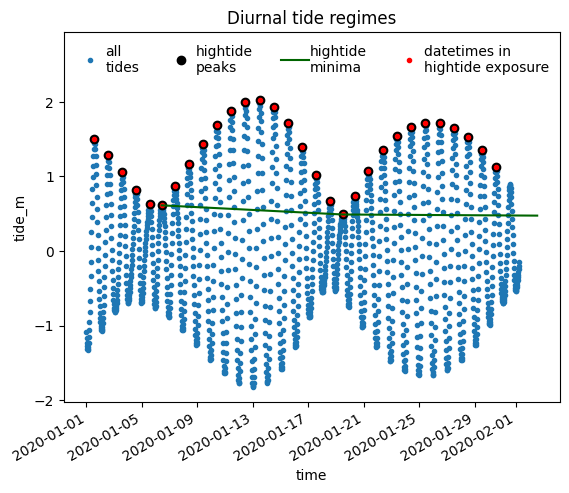

In [17]:
## Lowtide peaks
stacked_everything[0:1500].plot(marker='.',linestyle='', zorder=1, label='all\ntides')
high_peaks2[0:30].plot(marker='o',linestyle='', zorder=2, label='hightide\npeaks', color='black')
lowhigh_peaks2[0:3].plot(zorder=10, label='hightide\nminima', color='darkgreen')
# hightide[0:440].plot(marker='.',linestyle='', zorder=2, label='datetimes in\nhightide exposure', color='red')

high_peaks2[0:30].plot(marker='.',linestyle='', zorder=3, label='datetimes in\nhightide exposure', color='red')

plt.title('Diurnal tide regimes')
plt.ylim(top=stacked_everything.max()*1.25)
plt.legend(frameon=False, loc='upper left', ncol=4, handletextpad=0.1)
plt.savefig(fname='Diurnal regimes_updated')

In [ ]:
stacked_everything[0:int(len(stacked_everything)/3)].plot()
plt.title('Diurnal inequality tides over one year')
plt.savefig(fname='Diurnal_inequality_tides_1_year')
# int(len(stacked_everything)/2)

In [ ]:
## after https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
from scipy import stats

In [ ]:
restest = stats.linregress(np.arange(0,len(lowhigh_peaks2)),lowhigh_peaks2)

In [ ]:
# plt.plot(np.arange(0,len(lowhigh_peaks2)), lowhigh_peaks2, marker='.', linestyle='', color='darkgreen', label='hightide minima')
lowhigh_peaks2.plot(marker='.', linestyle='', color='darkgreen', label='hightide minima')
plt.plot(lowhigh_peaks2.time, restest.intercept + restest.slope*(np.arange(0,len(lowhigh_peaks2))), color='orange', label=f'R-squared: {restest.rvalue**2:.6f} \nSlope (95%): {restest.slope:.6f}\nStderror: {restest.stderr:.6f}')
plt.legend()
plt.title('Diurnal inequality regime\nhightide minima linear regression')
plt.savefig(fname='Diurnal_inequality_regime_hightide_minima_linear_regression')

In [ ]:
print(f"R-squared: {restest.rvalue**2:.6f}")

In [ ]:
# print(f'slope (95%): {restest.slope:.6f}\nstderror: {restest.stderr:.6f}')
order_nh

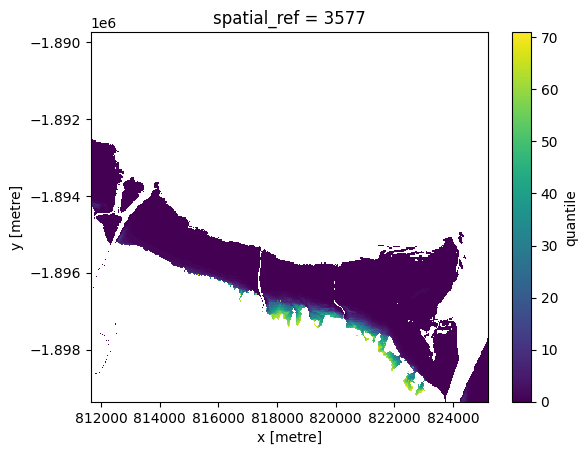

In [18]:
exposure['Hightide'].plot()
plt.savefig(fname='Diurnal_regime_updated_hightide_exposure')

In [69]:
%store -r tide_cq_dict

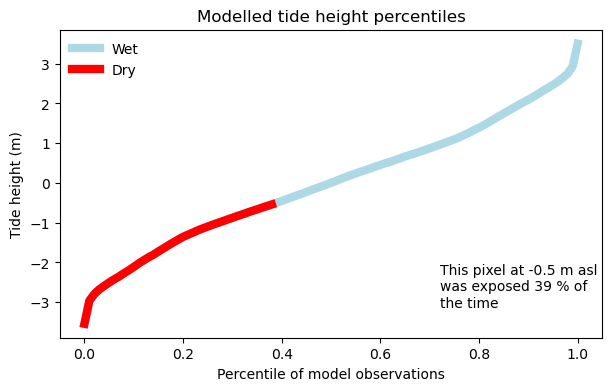

In [151]:
tidem = -0.5
exp = abs(tide_cq_dict['unfiltered'].isel(x=1,y=1) - tidem).idxmin(dim='quantile')*100

plt.figure(figsize=[7,4])

tide_cq_dict['unfiltered'].isel(x=1,y=1).plot(label='Wet', color='lightblue', linewidth=6)
tide_cq_dict['unfiltered'].isel(x=1,y=1).where(tide_cq_dict['unfiltered'].isel(x=1,y=1) <= tidem).plot(color='red', label='Dry', linewidth=6)
plt.title('Modelled tide height percentiles')
plt.ylabel('Tide height (m)')
plt.xlabel('Percentile of model observations')
plt.legend(frameon=False)
plt.annotate(f'This pixel at {tidem} m asl\nwas exposed {int(exp.values)} % of\nthe time', (0.7, 0.1), xycoords='axes fraction')
plt.savefig(fname='Exposure method concept model')

In [97]:
diff = abs(tide_cq_dict['unfiltered'].isel(x=1,y=1) - -0.5)#.where(tide_cq_dict['unfiltered'].isel(x=1,y=1) == -0.5)
idxmin = diff.idxmin(dim='quantile')*100

int(idxmin.values)
# diff

39

In [ ]:
# exposure['Neap_high'].plot()
int(ceil((len(Max_testarray.time)/(len(stacked_everything_peaks))/2)))
# len(stacked_everything_peaks)
# len(Max_testarray.time)
# stacked_everything.isel(time=Max_testarray)
# order

testc = argrelmax(stacked_everything2.tide_m.values, order=order_nh)[0] #order_nh

stacked_everything2.tide_m[0:340].plot(marker='o')
Max_testarray.tide_m.isel(time=testc).mean(dim=["x","y"])[0:16].plot(marker='o',color='red')


In [ ]:
testb = stacked_everything.isel(time=argrelmin(stacked_everything.values)[0])

In [ ]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
stacked_everything[0:600].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:6].plot()
stacked_everything2.tide_m[0:100].plot(marker='o')
# testb[0:100].plot(marker='o')
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neap_peaks).mean(dim=["x","y"])[0:6].plot(marker='o',color='red')
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
stacked_everything[0:1200].plot()
stacked_everything.isel(time=stacked_everything_peaks)[0:10].plot()
# stacked_everything2.tide_m.sel(time=neaphighs_all).plot()
Max_testarray.tide_m.isel(time=neaphighs_all).mean(dim=["x","y"])[0:10].plot()
# neappeaks.plot()
# springpeaks.plot()#.isel(time=stacked_everything_peaks2).plot()
# test.plot()

In [ ]:
print(len(Max_testarray.time))
len(stacked_everything2.tide_m)

In [ ]:
fig = ds[['exposure_unfiltered', 
          'exposure_Neap_low',
          'exposure_Lowtide',
          'exposure_Dry',
          'exposure_Winter',
          'exposure_Winter_Lowtide']].to_array().plot(col='variable', col_wrap=2)

for ax in fig.axs.flat:
    ax.label_outer()
    ax.set_xticklabels(labels="")
    ax.set_yticklabels(labels="")
    ax.set_xlabel("")
    ax.set_ylabel("")

In [ ]:
list = ['a','b','c','d']

for x in list:
    # if x == 'a' or x== 'b':
    if x in ['a','b','f','x']:
    # if x == 'a'|'b':
        print (x)
    else:
        print('not in list')

In [ ]:
if x == 'Neap_high':
    print ('Calculating Neap_high')
    ## Calculate the number of spring high tides to support calculation of neap highs
    ## apply the peak detection routine
    stacked_everything_high = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values, order=order)[0]))
    ## Unstack
    springhighs_all = stacked_everything_high.unstack('z')

    ## apply the peak detection routine to calculate all the high tide maxima
    Max_testarray = stacked_everything.apply(lambda x: xr.DataArray(argrelmax(x.values)[0]))
    ## extract the corresponding dates from the peaks
    Max_testarray = (Max_testarray.unstack('z'))
    Max_testarray = (Max_testarray.reindex(y=Max_testarray.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract all hightide peaks
    # Max_testarray = ModelledTides[0].to_dataset().isel(time=Max_testarray.time)
    Max_testarray = ModelledTides.to_dataset().isel(time=Max_testarray.time)## removed reference to ModelledTides[0]. Possibly an artefact of new pixel_tides_ensemble func. If using pixel_tides, may need to revert to ModelledTides[0].

    ## repeat the peak detection to identify neap high tides (minima in the high tide maxima)
    stacked_everything2 = Max_testarray.tide_m.stack(z=['y','x']).groupby('z')
    ## extract neap high tides based on 14 day half lunar cycle - determined as the fraction of all high tide points
    ## relative to the number of spring high tide values
    order_nh = int(ceil((len(Max_testarray.time)/(len(springhighs_all))/2)))
    ## apply the peak detection routine to calculate all the neap high tide minima within the high tide peaks
    neaphighs_all = stacked_everything2.apply(lambda x: xr.DataArray(argrelmin(x.values, order=order_nh)[0]))
    ## unstack and format as above                                    
    neaphighs_all = neaphighs_all.unstack('z')
    neaphighs_all = (
                    neaphighs_all
                     .reindex(y=neaphighs_all.y[::-1])
                     .rename({'dim_0':'time'})
                     .to_dataset(name = 'time')
                     [['time','y','x']]
                    )
    ## extract neap high tides
    neaphighs_all = Max_testarray.isel(time=neaphighs_all.time)

    ## Save datetimes for calculation of combined filter exposure
    timeranges['Neap_high'] = pd.to_datetime(neaphighs_all.isel(x=1,y=1).time)

    tide_cq = neaphighs_all.tide_m.quantile(q=calculate_quantiles,dim='time')

    # Add tide_cq to output dict
    tide_cq_dict[str(x)]=tide_cq

    # Calculate the tide-height difference between the elevation value and
    # each percentile value per pixel
    diff = abs(tide_cq - dem)

    # Take the percentile of the smallest tide-height difference as the
    # exposure % per pixel
    idxmin = diff.idxmin(dim="quantile")

    # Convert to percentage
    exposure['Neap_high'] = idxmin * 100


In [ ]:
stacked_everything_high[0]

In [ ]:
stacked_everything

In [ ]:
stacked_everything.plot()
stacked_everything.isel(time=stacked_everything_high).plot()

In [ ]:
def highestlowtides(z):
    '''
    x is a grouping of x and y pixels from the peaks_array (labelled as 'z')
    '''

    ## apply the peak detection routine to calculate all the high tide maxima
    low_peaks = np.array(argrelmin(z.values)[0])

    ## extract all hightide peaks
    Min_testarray = z.isel(time=low_peaks)

    ## Identify all lower hightide peaks
    highlow_peaks = np.array(argrelmax(Min_testarray.values)[0])

    ## Interpolate the lower hightide curve
    neap_low_linear = interp(
                            ## Create an array to interpolate into
                            np.arange(0,len(z.time)),
                            ## low high peaks as a subset of all high tide peaks
                            low_peaks[highlow_peaks],
                            ## Corresponding tide heights
                            Min_testarray.isel(time=highlow_peaks).squeeze(['z']).values,
                            )

    # # Extract hightides as all tides higher than/equal to the extrapolated lowest high tide line
    lowtide = z.squeeze(['z']).where(z.squeeze(['z']) <= neap_low_linear, drop=True)

    return lowtide 

In [ ]:
## Vectorise the lowtide calculation
highlows_all = stacked_everything.apply(lambda x: xr.DataArray(highestlowtides(x)))
# highlows_all = stacked_everything.map(lambda y: xr.DataArray(highestlowtides(y)))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

stacked_everything[0:300].plot(marker='.', linestyle='', color='blue', zorder=10)
low_peaks2[0:70].plot(linestyle='', color='orange')
highlow_peaks2[0:30].plot(linestyle='', color='g')
plt.plot(stacked_everything.time[0:300], high_low_linear[0:300])
lowtide[0:100].plot(marker='o', color='black', zorder=1, linestyle='')

In [ ]:
# calculate all the low tide maxima
low_peaks = argrelmin(stacked_everything.values)[0]

# extract all lowtide peaks
low_peaks2 = stacked_everything.isel(time=low_peaks)

# identify all higher lowtide peaks
highlow_peaks = argrelmax(low_peaks2.values)[0]

# extract all higher lowtide peaks
highlow_peaks2 = low_peaks2.isel(time=highlow_peaks)

# interpolate the higher lowtide curve
high_low_linear = interp(np.arange(0,len(stacked_everything)),
                         low_peaks[highlow_peaks],
                         highlow_peaks2.values)
# Extract all tides lower than/equal to the extrapolated higher lowtide line
lowtide = stacked_everything.where(stacked_everything <= high_low_linear, drop=True)

## Save datetimes for calculation of combined filter exposure
timeranges['Lowtide'] = pd.to_datetime(lowtide.time)

tide_cq = lowtide.quantile(q=calculate_quantiles,dim='time').to_dataset()

In [ ]:
tide_cq.to_dataset()

In [ ]:
stacked_everything